In [1]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
import scipy.optimize as so
from scipy.interpolate import interp1d

# from jupyter_server import serverapp as app; 
# import ipykernel, requests;

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')


plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [2]:
# home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [3]:
import analysis.mathematical_functions.funcs as funcs

In [11]:
data_folder = project_path+'/data/parameter_runs/many_kappas/'
# os.listdir(project_path+'')
data_files = os.listdir(data_folder)
data_files = [data_folder+'/'+f for f in data_files if f.endswith('_feather')]
dataframes = [pd.read_feather(f) for f in data_files]

In [12]:
data_files

['../data/parameter_runs/many_kappas//01-10-19--04-06-2023abm_result_feather']

In [14]:
if len(dataframes)==1:
    datadf = dataframes[0]

In [15]:
datadf['first_tb'].unique()

array([29.47310585, 20.68064554,         inf, ..., 10.84717367,
        5.99631146,  3.10555556])

In [16]:

@jit(nopython=True)
def p_surv(fit,t_lim,dt,reg= 1e-3):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv
            

def product_sum_probas(S,I, t_lim, R0, kappa,xi,ds,dt, N, p_alpha):
    x,y = S/N, I/N
    z = 1-x-y
    
    fit_d = lambda d: R0/(1+y*kappa) * ( x + (1- np.exp(-d/xi))*z )-1

    product_sum = 0
    
    L = len(ds)
    for i in range(L):
        d= ds[i]
        fit = fit_d(d)
        p_surv_t = p_surv(fit,t_lim, dt)
        product_sum +=funcs.rho_d(d=d,p_alpha=p_alpha )*p_surv_t
    
    return product_sum

def product_sum_probas_adiabatic(S,I, t_lim, R0, kappa,xi,ds,dt, N, p_alpha):
    x,y = S/N, I/N
    z = 1-x-y
    
    fit_d = lambda d: R0/(1+y*kappa) * ( x + (1- np.exp(-d/xi))*z )-1

    product_sum = 0
    
    L = len(ds)
    for i in range(L):
        d= ds[i]
        fit = fit_d(d)
        p_surv_t = np.maximum(0,1 - 1/(1+fit))
        product_sum +=funcs.rho_d(d=d,p_alpha=p_alpha )*p_surv_t
    
    return product_sum

In [17]:


def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))

def integrate_trajectory(R0,kappa,N, I0=10):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 3*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,10000)
    dt = ts[1]-ts[0]
    y = odeint(model_w_params(R0,N,kappa),y0,ts).T

    return ts, y

def get_exp_num_established(R0, kappa, p_alpha,xi, N,pbar = None):
    ts, solution= integrate_trajectory(R0,kappa,N)
    ds = np.arange(1,int(10/p_alpha)+1)

    S,I = solution
    t2 = ts[-1]
    dt = ts[1]-ts[0]
    idx_times = ts<t2
    prod_sum_prob = product_sum_probas(S,I, t2, R0, kappa,xi,ds,dt, N, p_alpha)

    try:
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
    except ValueError:
        idx_times = ts<=t2
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
    if pbar is not None:
        pbar.update(1)
    return exp_number_est_mutants

def get_exp_num_established_adiabatic(R0, kappa, p_alpha,xi, N):
    ts, solution= integrate_trajectory(R0,kappa,N)
    ds = np.arange(1,int(10/p_alpha)+1)

    S,I = solution
    t2 = ts[-1]
    dt = ts[1]-ts[0]
    idx_times = ts<t2
    prod_sum_prob = product_sum_probas_adiabatic(S,I, t2, R0, kappa,xi,ds,dt, N, p_alpha)
    try:
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
    except ValueError:
        idx_times = ts<=t2
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
        
    return exp_number_est_mutants

In [18]:
R0 = 2.5
N = 1e8
mu_s = np.logspace(0,3,501, base =10)/N
kappa_s = np.concatenate([np.array([0]), np.logspace(0,3,21,base=10)])
dbar = 50
delta_s= np.logspace(-2,0,30, base =10)
xi_s= dbar/delta_s
R0s = np.logspace(np.log10(1.5),1,10)

if os.path.exists(os.getcwd()+'/pickles/exp_t_dep_nums_df_modulo_mu_mountain_big_d.feather'):
    exp_t_dep_nums_df_modulo_mu_mountain = pd.read_feather(os.getcwd()+'/pickles/exp_t_dep_nums_df_modulo_mu_mountain_big_d.feather')
else:
    pbar = tqdm(total = len(kappa_s)*len(xi_s)*len(R0s))
    exp_t_dep_nums_df_modulo_mu_mountain = pd.DataFrame.from_dict(
        {i:(R0, kappa,  N, dbar, xi,
            get_exp_num_established(R0=R0, kappa = kappa, p_alpha=1/dbar,xi = xi, N=N, pbar = pbar)) 
            for i, (R0,kappa,xi) 
            in enumerate(
                funcs.product(R0s, kappa_s, xi_s))
                }, orient='index', columns=['R0', 'kappa', 'N', 'dbar', 'xi','exp_num_est_mutants_mod_mu'])
    exp_t_dep_nums_df_modulo_mu_mountain.to_feather(os.getcwd()+'/pickles/exp_t_dep_nums_df_modulo_mu_mountain_big_d.feather')

In [19]:
evolution_pd = pd.DataFrame(columns=['R0', 'kappa', 'N', 'mu', 'dbar', 'xi','exp_num_est_mutants_mod_mu'])

for mu in mu_s:
    evolution_pd = pd.concat([evolution_pd, exp_t_dep_nums_df_modulo_mu_mountain.assign(mu=mu)], ignore_index=True)
    
evolution_pd['exp_num_est_mutants'] = evolution_pd['exp_num_est_mutants_mod_mu']*evolution_pd['mu']
evolution_pd['p_evo']= 1- np.exp(-evolution_pd['exp_num_est_mutants'])
evolution_pd['scaled_dbar'] = evolution_pd['dbar']/evolution_pd['xi']
# evolution_pd['scaled_dbar'] = np.round(evolution_pd['scaled_dbar'].astype(float),1)
evolution_pd['muN'] = evolution_pd['mu']*evolution_pd['N']
evolution_pd['kappa_plot'] = 1 + evolution_pd['kappa']

/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_3997/1791401464.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evolution_pd = pd.concat([evolution_pd, exp_t_dep_nums_df_modulo_mu_mountain.assign(mu=mu)], ignore_index=True)


In [20]:
evolution_pd

R0   kappa            N            mu dbar           xi  \
0         1.5     0.0  100000000.0  1.000000e-08   50  5000.000000   
1         1.5     0.0  100000000.0  1.000000e-08   50  4265.839262   
2         1.5     0.0  100000000.0  1.000000e-08   50  3639.476922   
3         1.5     0.0  100000000.0  1.000000e-08   50  3105.084709   
4         1.5     0.0  100000000.0  1.000000e-08   50  2649.158453   
...       ...     ...          ...           ...  ...          ...   
3306595  10.0  1000.0  100000000.0  1.000000e-05   50    94.369591   
3306596  10.0  1000.0  100000000.0  1.000000e-05   50    80.513101   
3306597  10.0  1000.0  100000000.0  1.000000e-05   50    68.691190   
3306598  10.0  1000.0  100000000.0  1.000000e-05   50    58.605115   
3306599  10.0  1000.0  100000000.0  1.000000e-05   50    50.000000   

         exp_num_est_mutants_mod_mu  exp_num_est_mutants         p_evo  \
0                      7.318587e-07         7.318587e-15  7.327472e-15   
1                      7.399217e-07         7.399217e-15  7.438494e-15   
2                      7.502280e-07         7.502280e-15  7.549517e-15   
3                      7.620968e-07         7.620968e-15  7.660539e-15   
4                      7.761055e-07         7.761055e-15  7.771561e-15   
...                             ...                  ...           ...   
3306595                         NaN                  NaN           NaN   
3306596                         NaN                  NaN           NaN   
3306597                         NaN                  NaN           NaN   
3306598                         NaN                  NaN           NaN   
3306599                         NaN                  NaN           NaN   

        scaled_dbar     muN  kappa_plot  
0              0.01     1.0         1.0  
1          0.011721     1.0         1.0  
2          0.013738     1.0         1.0  
3          0.016103     1.0         1.0  
4          0.018874     1.0         1.0  
...             ...     ...         ...  
3306595    0.529832  1000.0      1001.0  
3306596    0.621017  1000.0      1001.0  
3306597    0.727895  1000.0      1001.0  
3306598    0.853168  1000.0      1001.0  
3306599         1.0  1000.0      1001.0  

[3306600 rows x 12 columns]

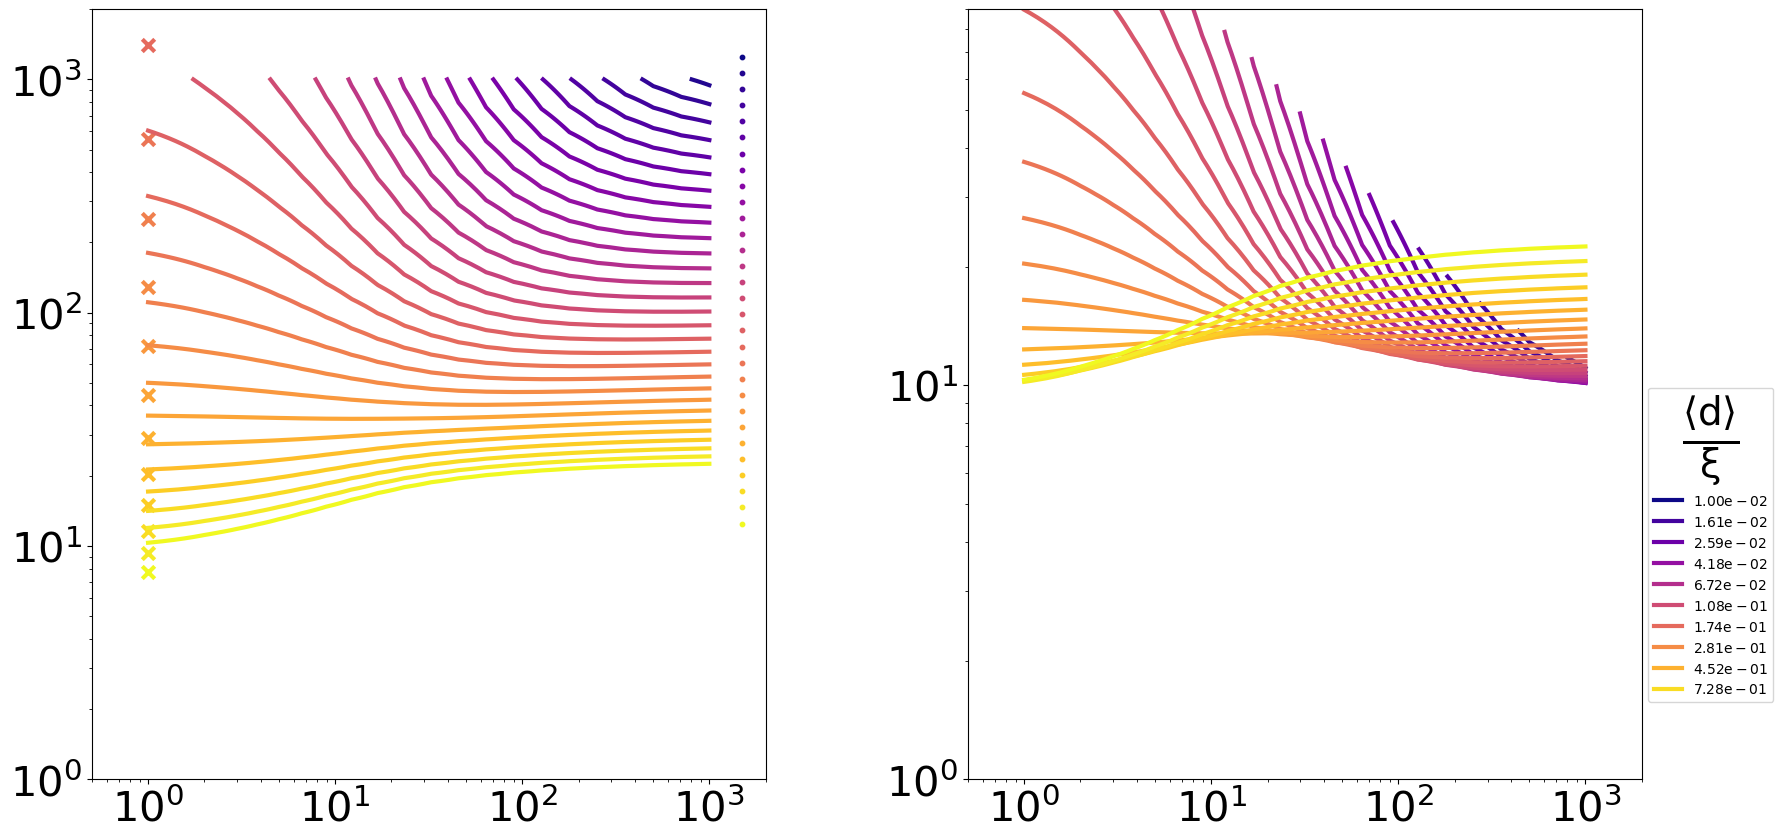

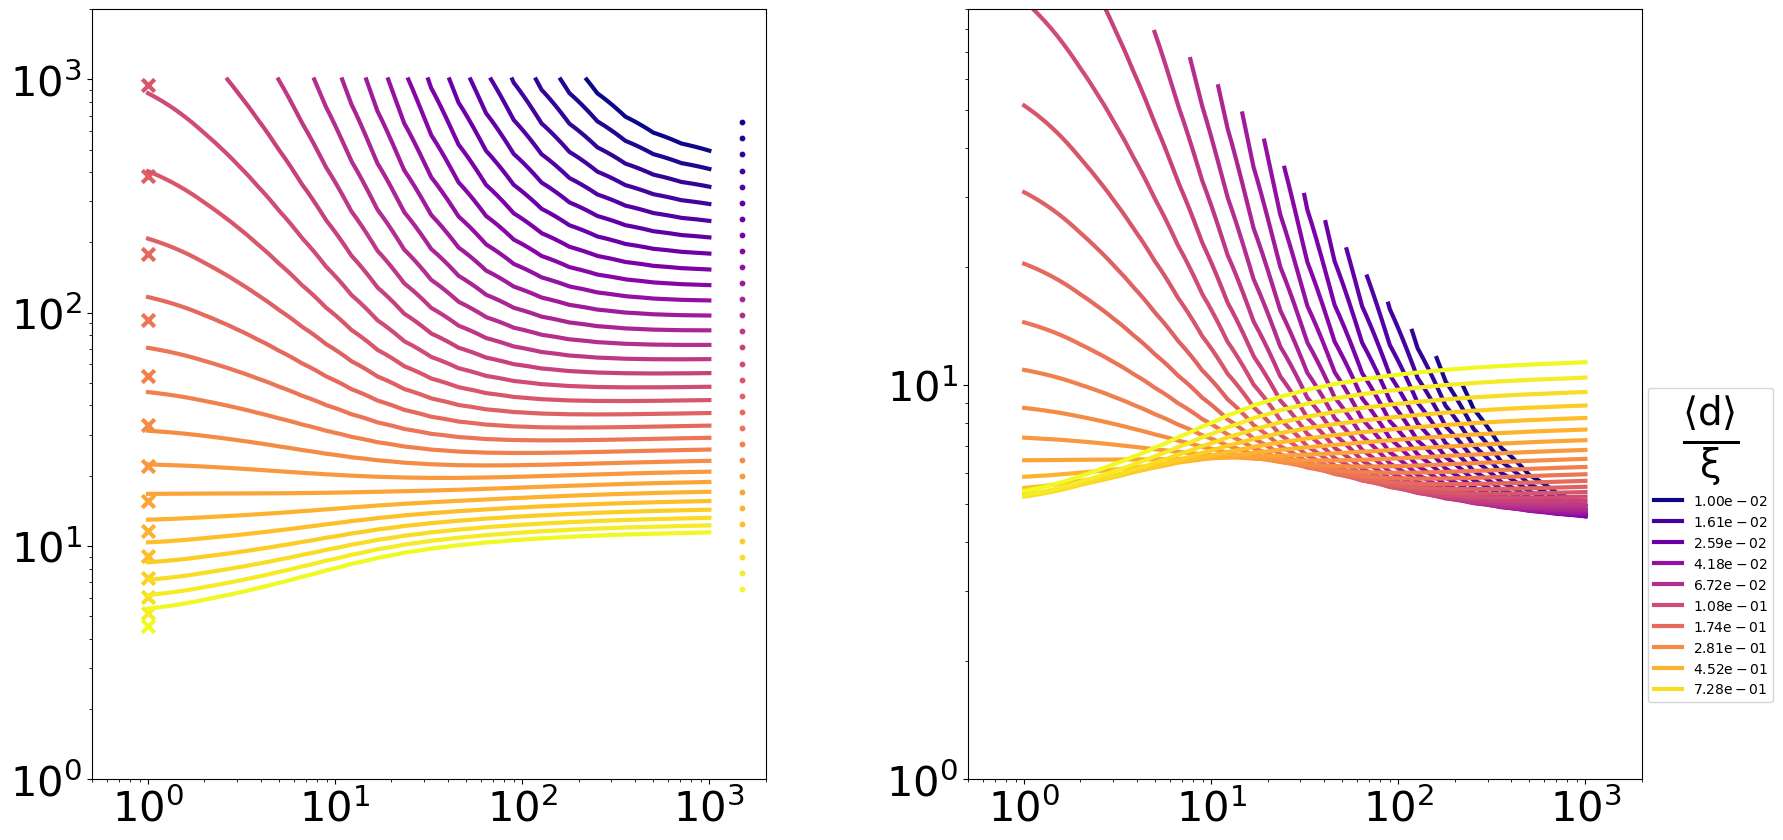

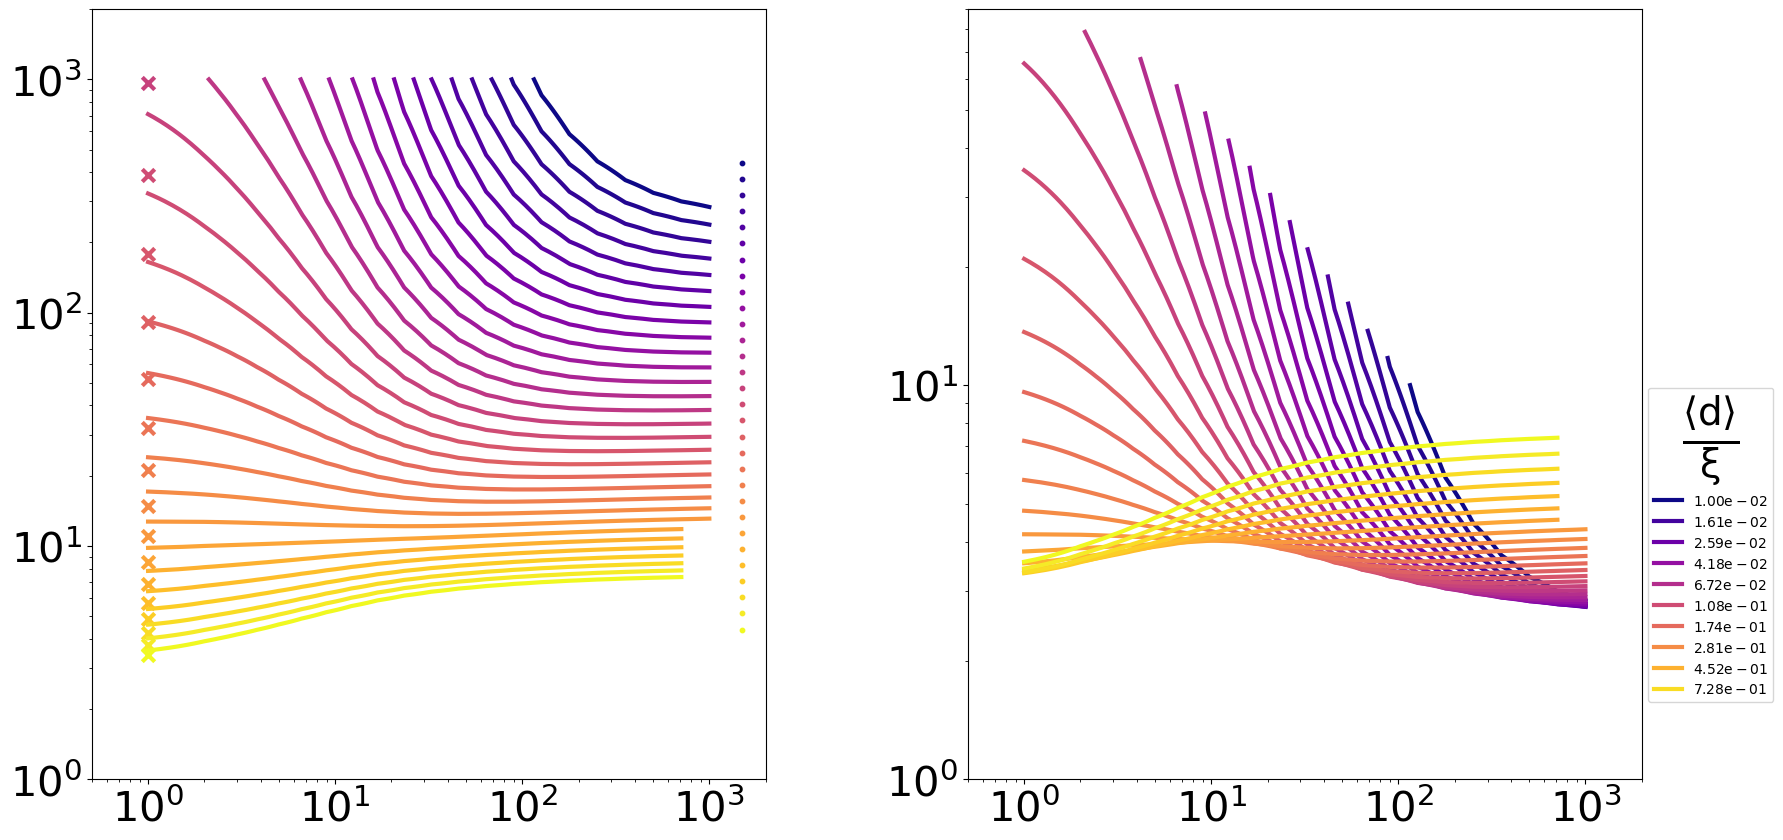

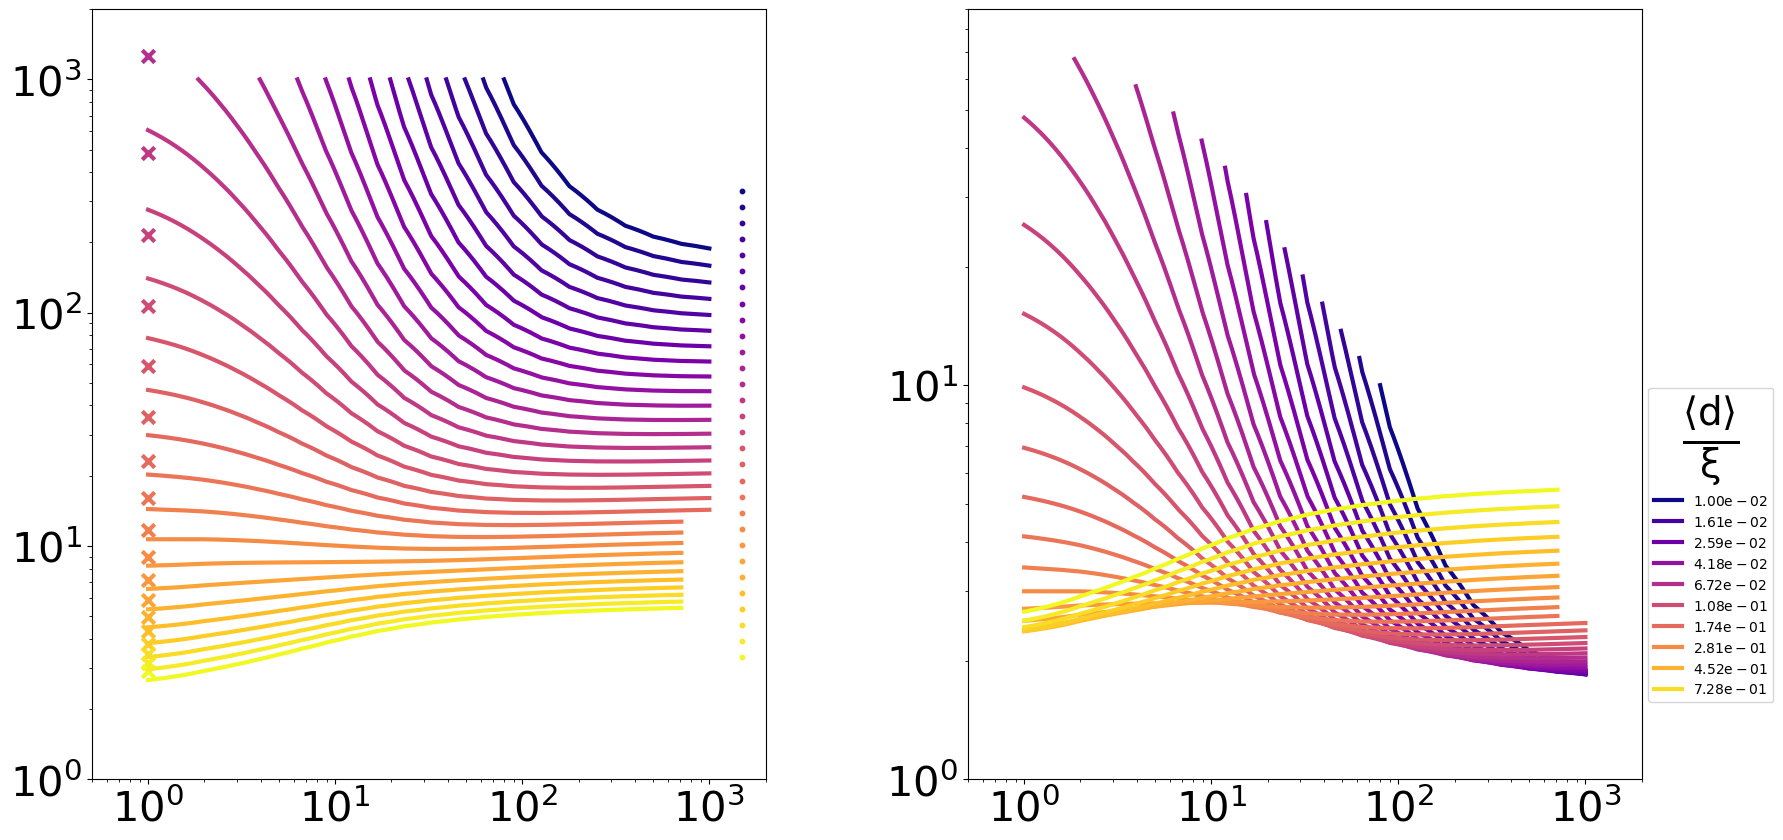

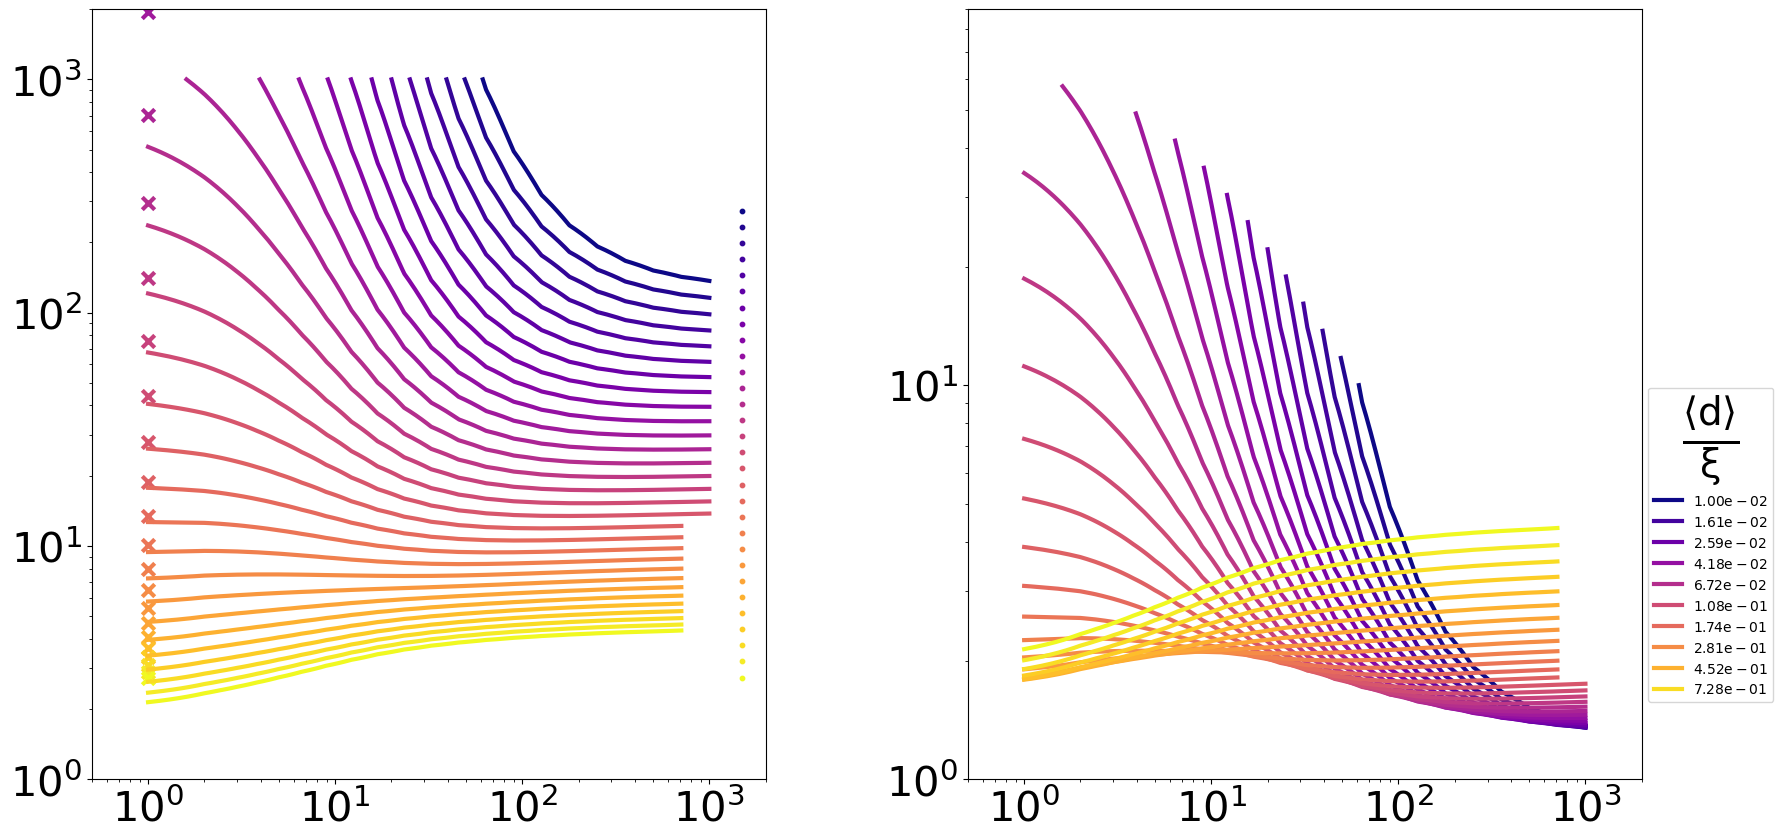

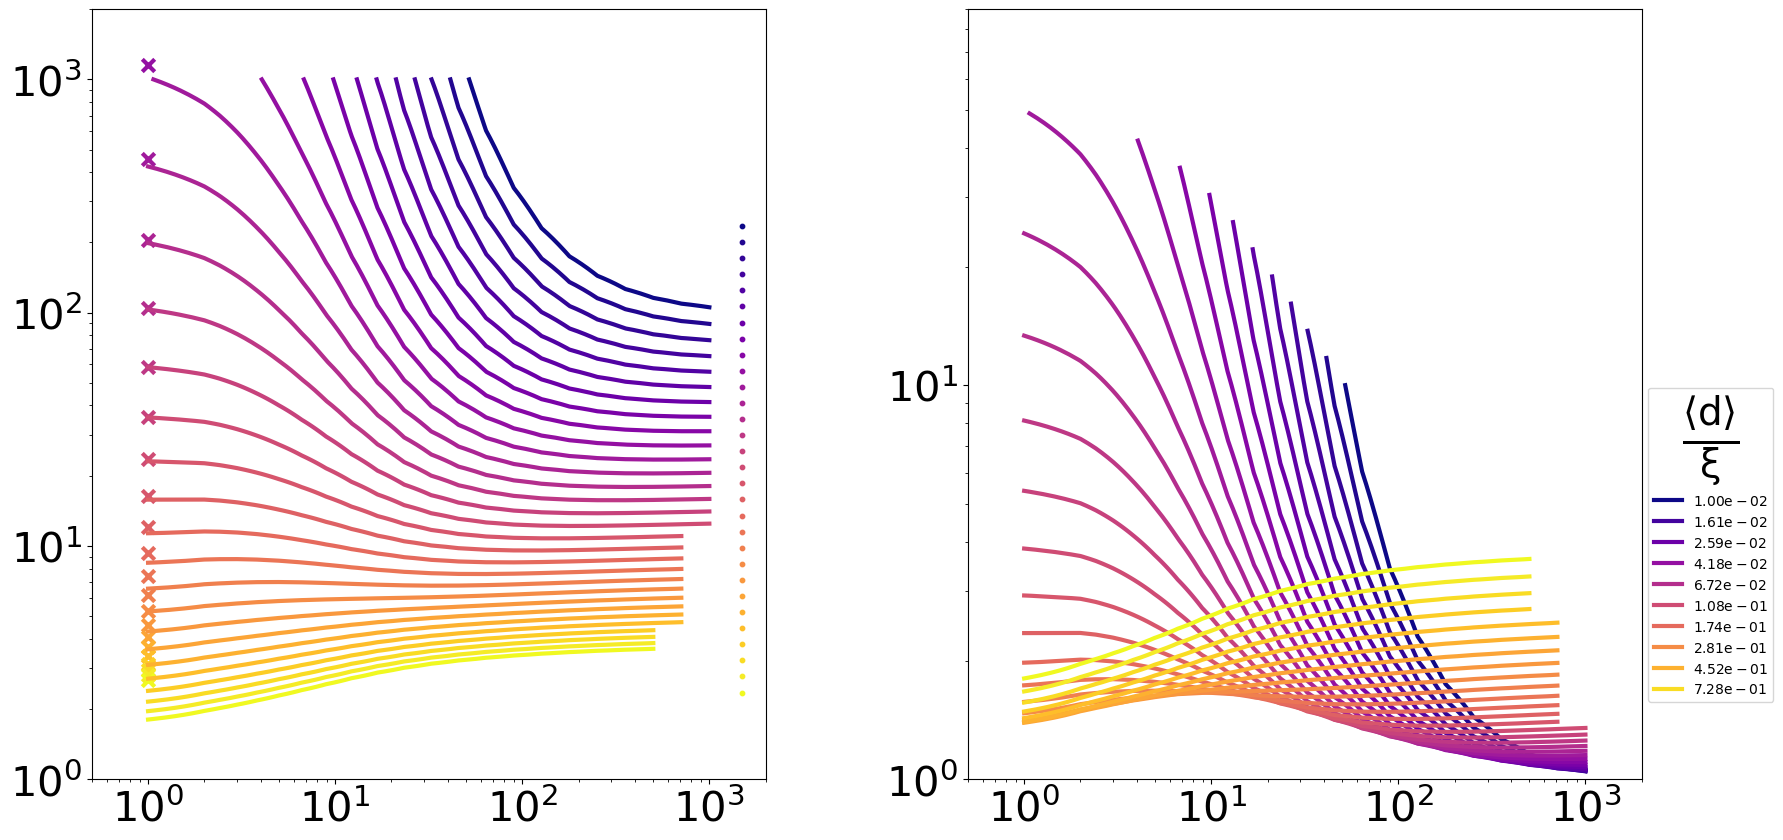

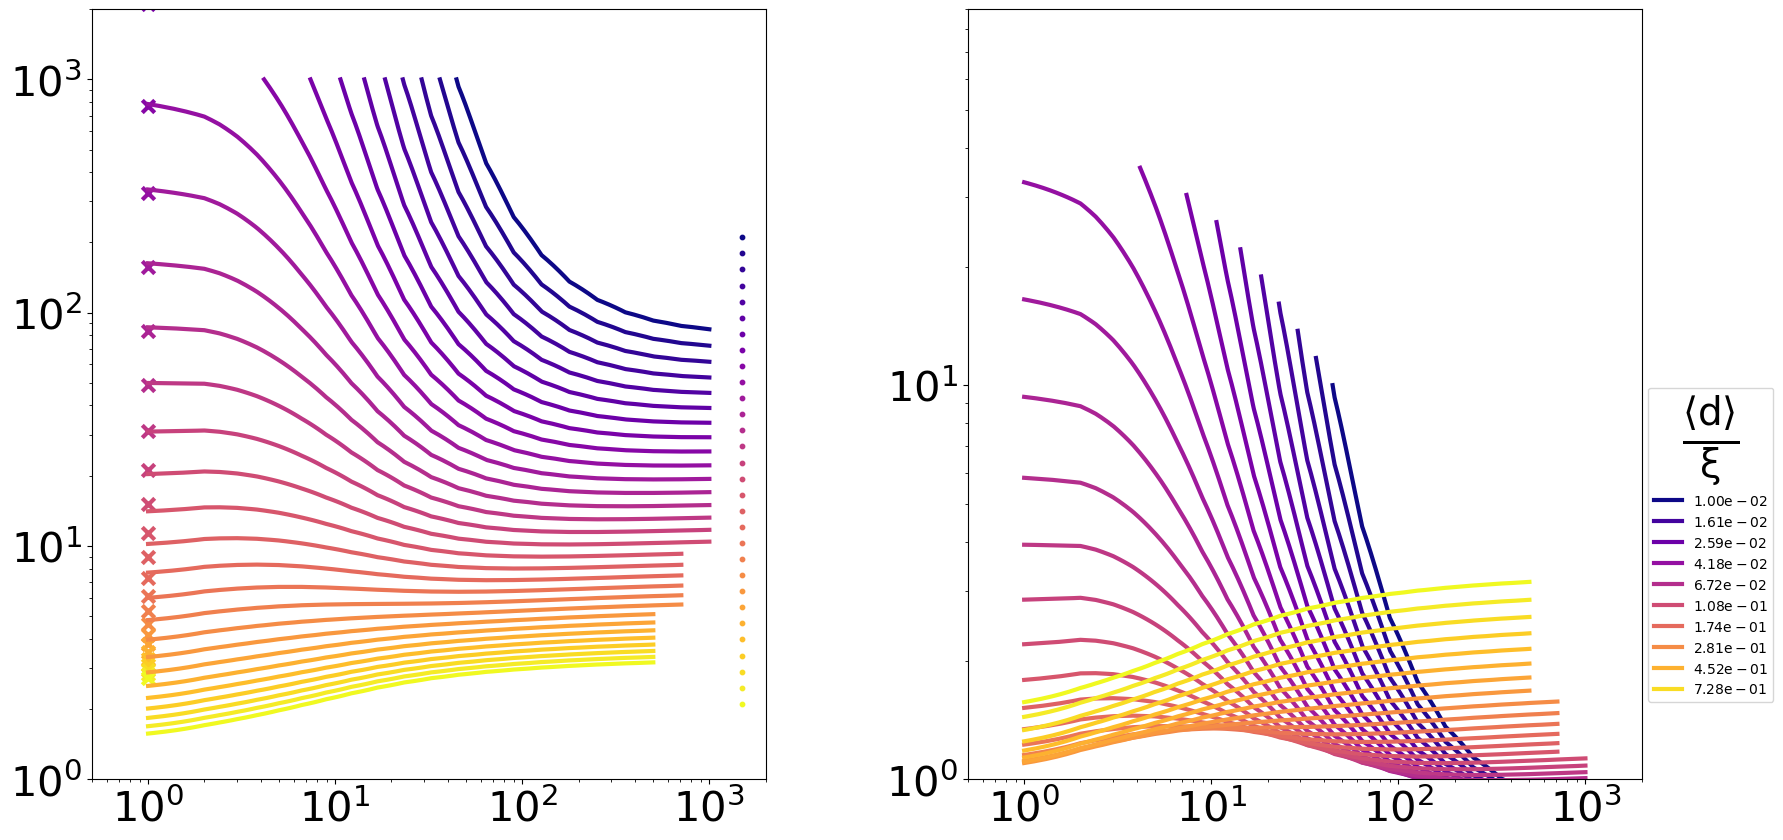

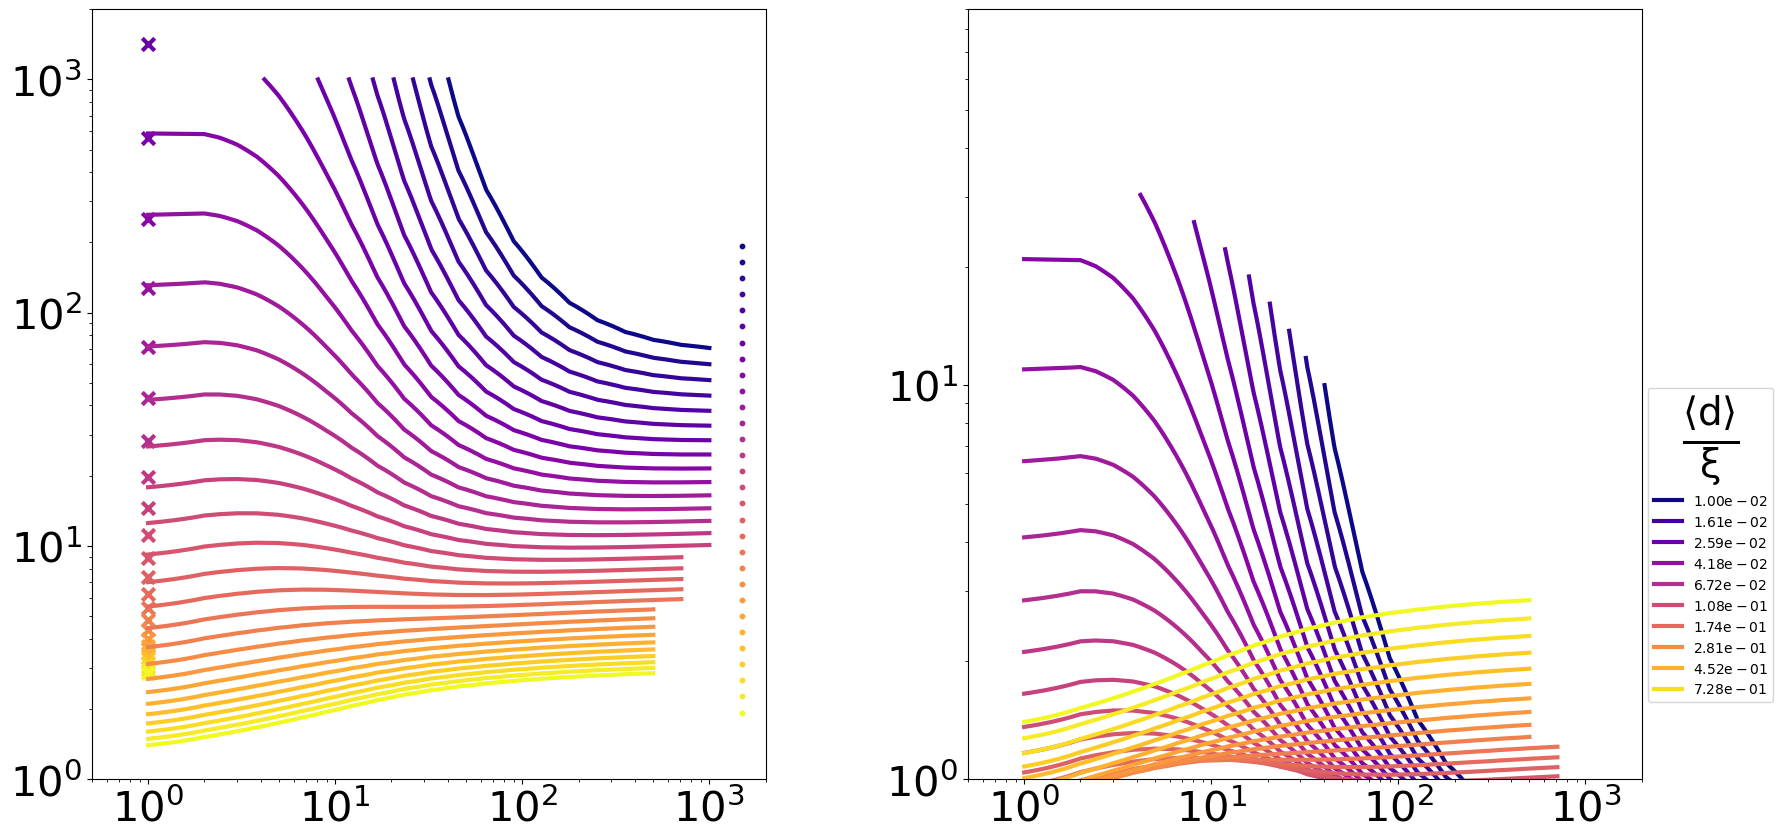

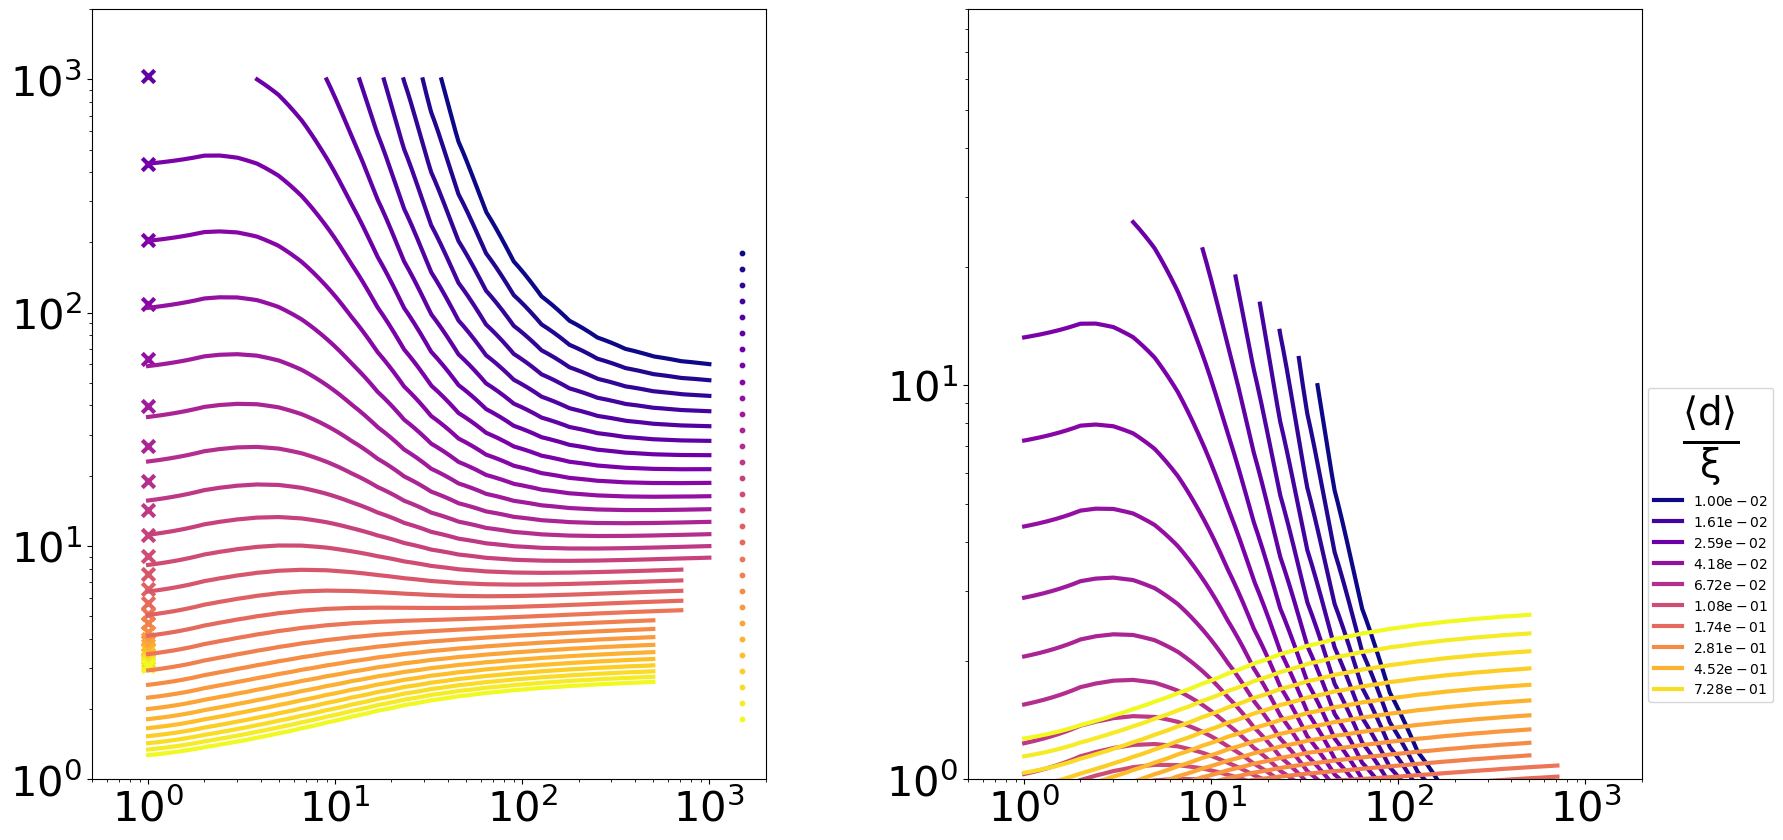

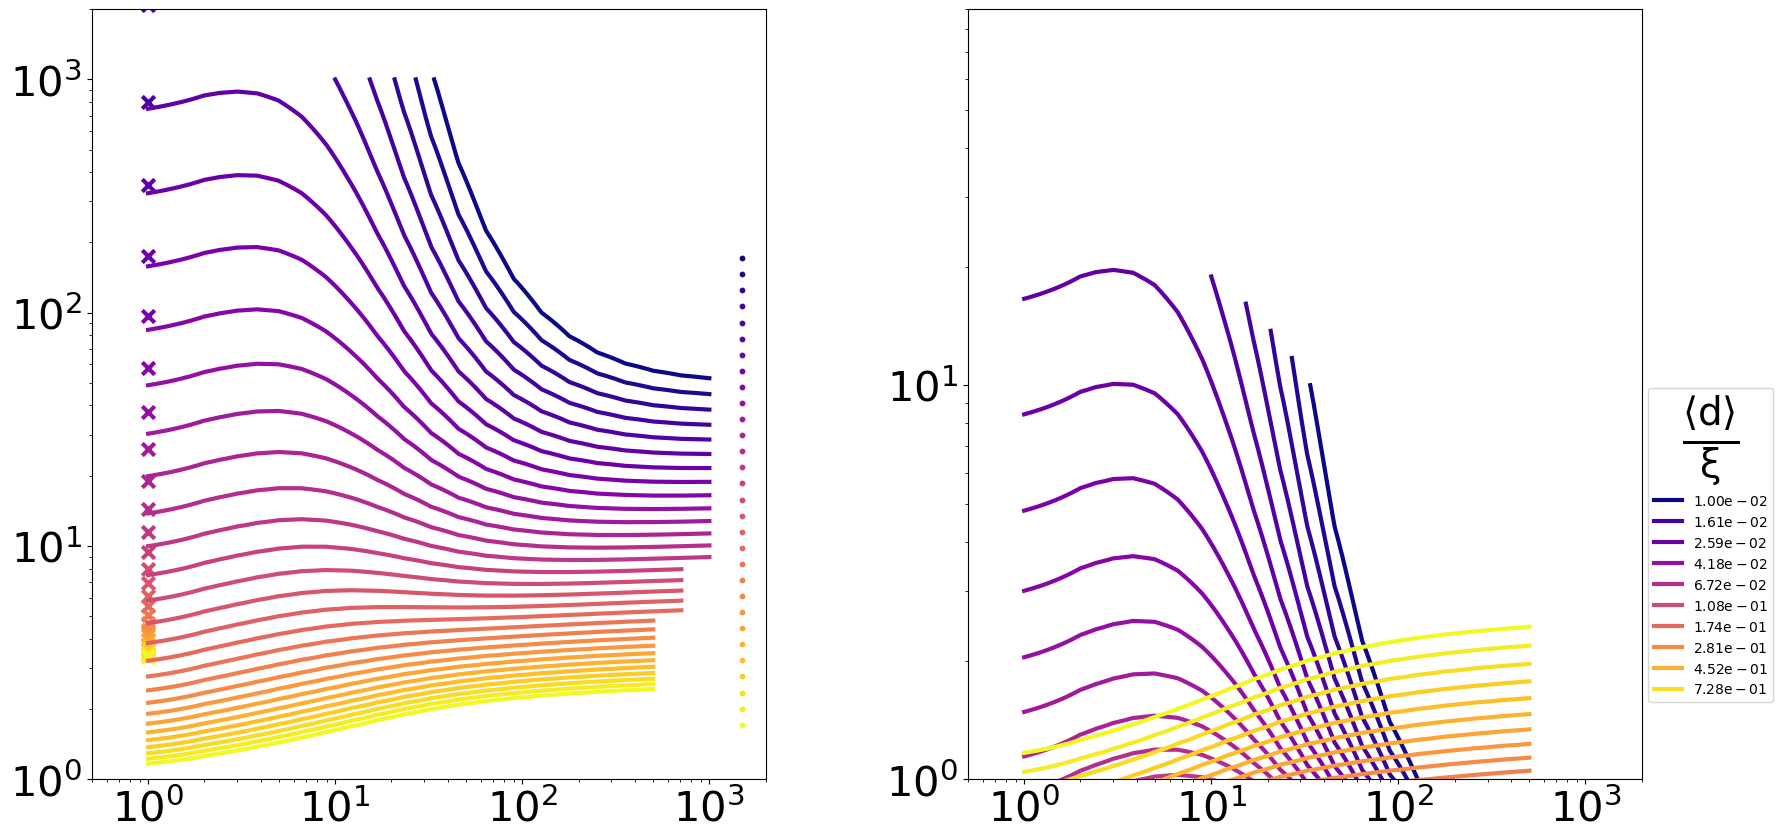

In [21]:
colors_scaled_dbar= funcs.color_dict(evolution_pd['scaled_dbar'].unique(),plt.cm.plasma)

for R0 in R0s:
    fig,ax= plt.subplots(1,2,figsize=(20,10))
    plt.subplots_adjust(wspace=0.3)

    delta_s_from_df = evolution_pd['scaled_dbar'].unique()
    for scaled_dbar in delta_s_from_df:
        mini_df = (evolution_pd
            .query(f'R0=={R0} and scaled_dbar=={scaled_dbar}')
            .groupby(['kappa_plot', 'muN'])
            .mean()
            .reset_index())
        
        muN_vals = mini_df['muN'].unique()
        kappa_vals = mini_df['kappa_plot'].unique()
        p_evo_vals = mini_df.pivot(index='muN', columns='kappa_plot', values='p_evo').values

        C =ax[0].contour(kappa_vals, muN_vals, p_evo_vals, levels=[0.5],alpha=0)
        Cx, Cy = C.allsegs[0][0].T
        ax[0].plot(Cx, Cy, color=colors_scaled_dbar[scaled_dbar], label = rf'${scaled_dbar:.2e}$')
        ax[1].plot(Cx, Cy*scaled_dbar, color=colors_scaled_dbar[scaled_dbar], label = rf'${scaled_dbar:.2e}$')

    ax[0].set_xlim(ax[0].get_xlim()*np.array([.5,2]))
    ax[1].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim()*np.array([.5,2]))
    ax[1].set_ylim(ax[1].get_ylim()*np.array([.5,2]))

    for xi in xi_s:
        delta = dbar/xi
        
        p_alpha= 1/dbar
        exp_val_kappa_inf = mu*N/(xi*p_alpha) * ((R0-1)/R0)**2 /2 # exp must be log 2
        exp_val_kappa0 = mu*N*np.log(R0)/(R0)*np.power(R0/(R0-1),-xi*p_alpha) # exp must be log 2

        equal_proba_point_kappa0 = np.log(2)/(np.log(R0)/(R0)*np.power(R0/(R0-1),-xi*p_alpha))
        equal_proba_point_kappa_inf = np.log(2)/(((R0-1)/R0)**2 /2)*(xi*p_alpha)
        # p_evo_kappa0 = 1- np.exp(-mu*N*np.log(R0)/(R0)*np.power(R0/(R0-1),-xi*p_alpha) )
        ax[0].scatter(1,equal_proba_point_kappa0, marker='x', color=colors_scaled_dbar[delta],s=80)
        ax[0].scatter(1.5*kappa_s[-1] ,equal_proba_point_kappa_inf, s=10, marker='o',color=colors_scaled_dbar[delta])


    handles, labels= ax[0].get_legend_handles_labels()
    handles = handles[::3]
    labels = labels[::3]


    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[0].set_xlabel(r'')
    ax[0].set_ylabel(r'')
    ax[1].set_xlabel(r'')
    ax[1].set_ylabel(r'')

    ax[1].set_xscale('log')
    ylogged = True 

    if ylogged:
        ax[1].set_yscale('log')

    ax[0].set_ylim((1,2e3))
    ax[1].set_ylim((1,90))

    ax[1].legend(handles,labels, title= r'$\frac{\langle d\rangle}{\xi}$',loc=(1.01,0.1), fontsize=10)
    # os.makedirs(os.getcwd()+'/figures', exist_ok=True)
    # plt.savefig(os.getcwd()+f'/figures/phase_diagram_mountain_logy{ylogged}.pdf', bbox_inches='tight')

In [22]:
#import linalgerror

from scipy.linalg import LinAlgError

In [23]:
import warnings

warnings.filterwarnings("ignore")

100%|██████████| 10/10 [02:25<00:00, 14.53s/it]


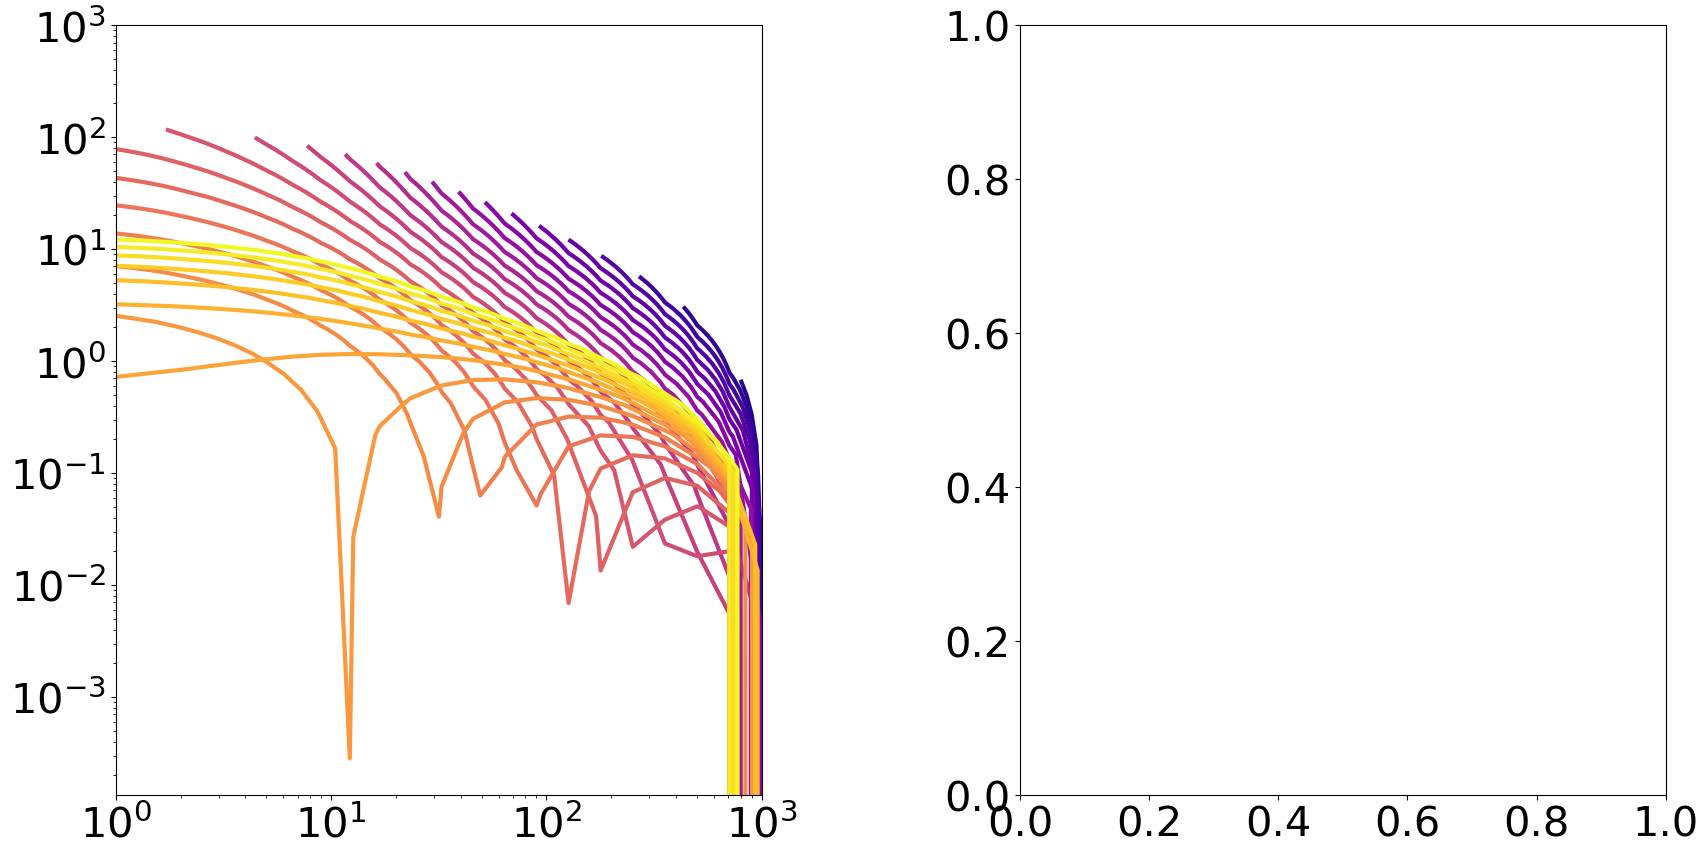

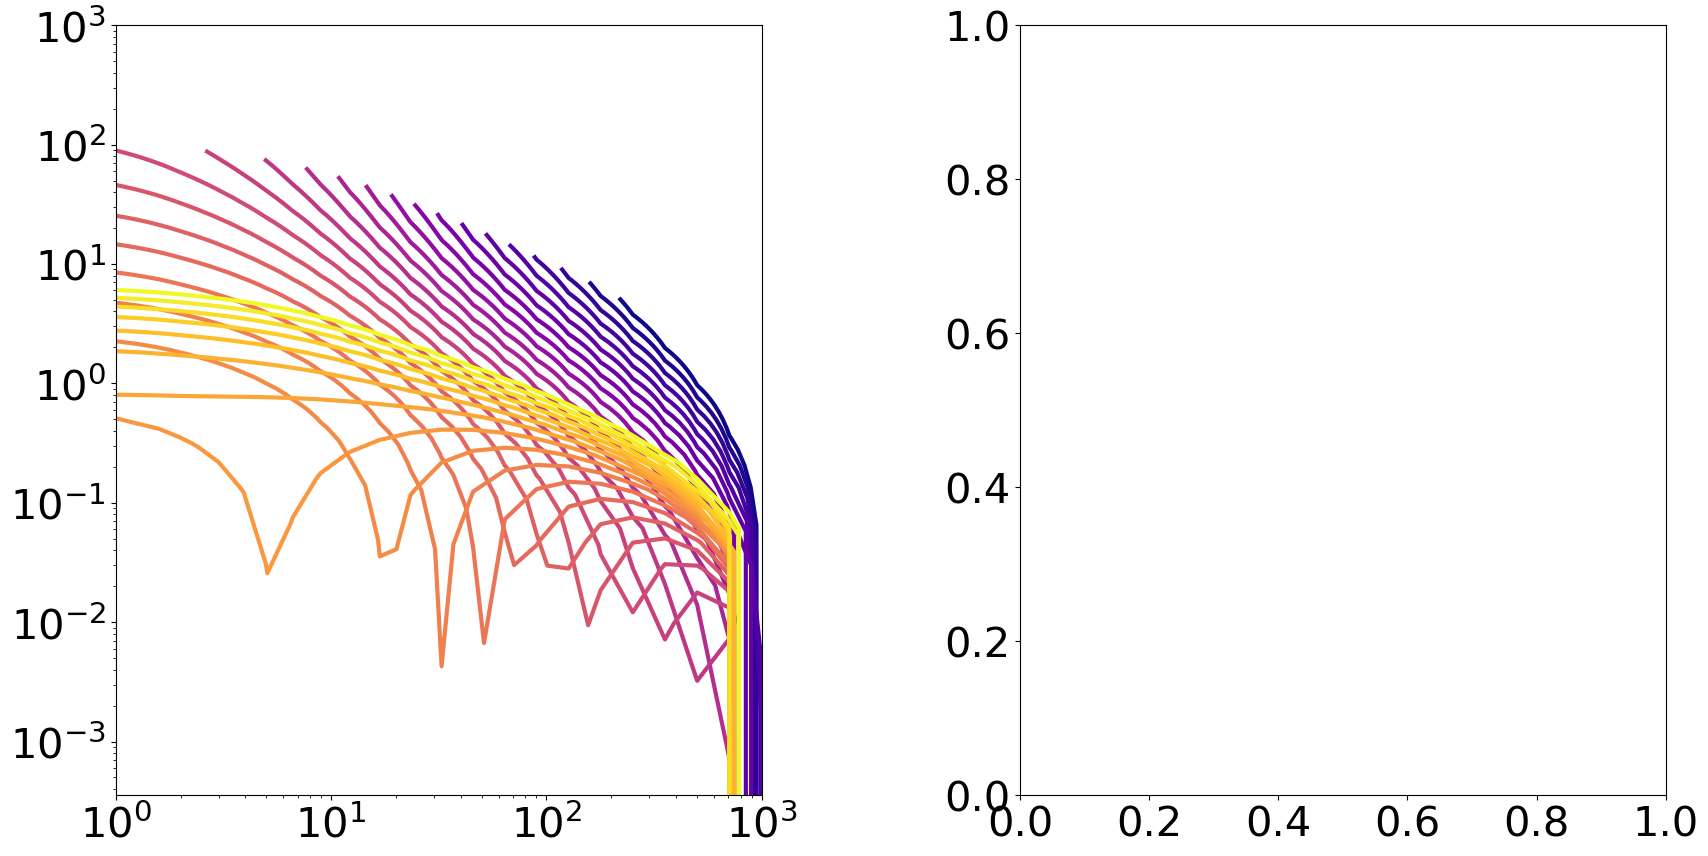

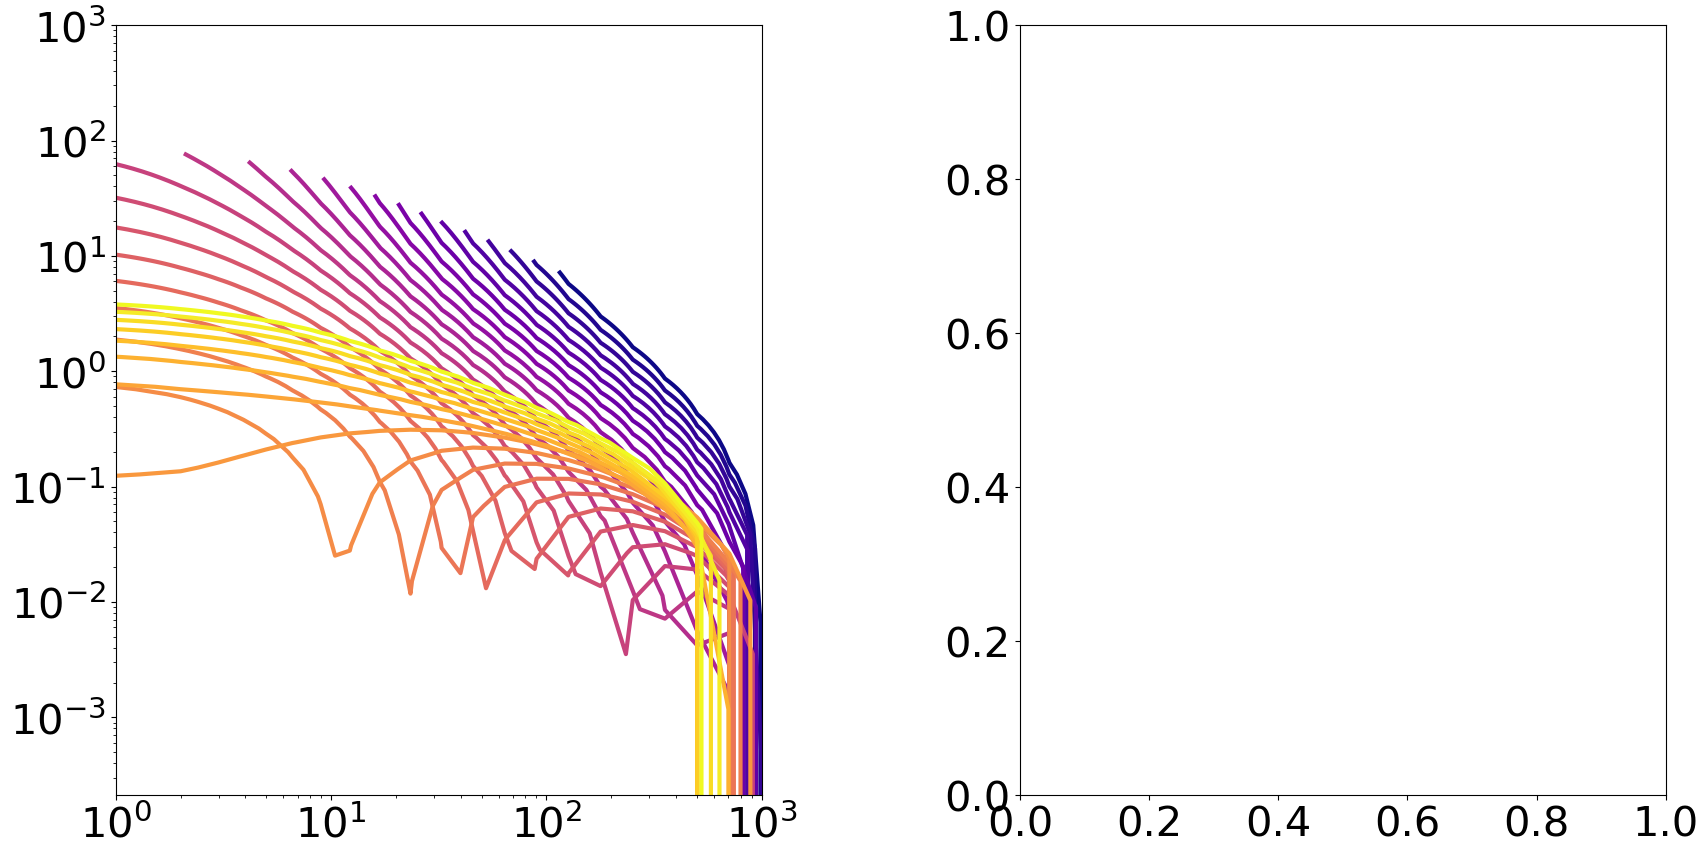

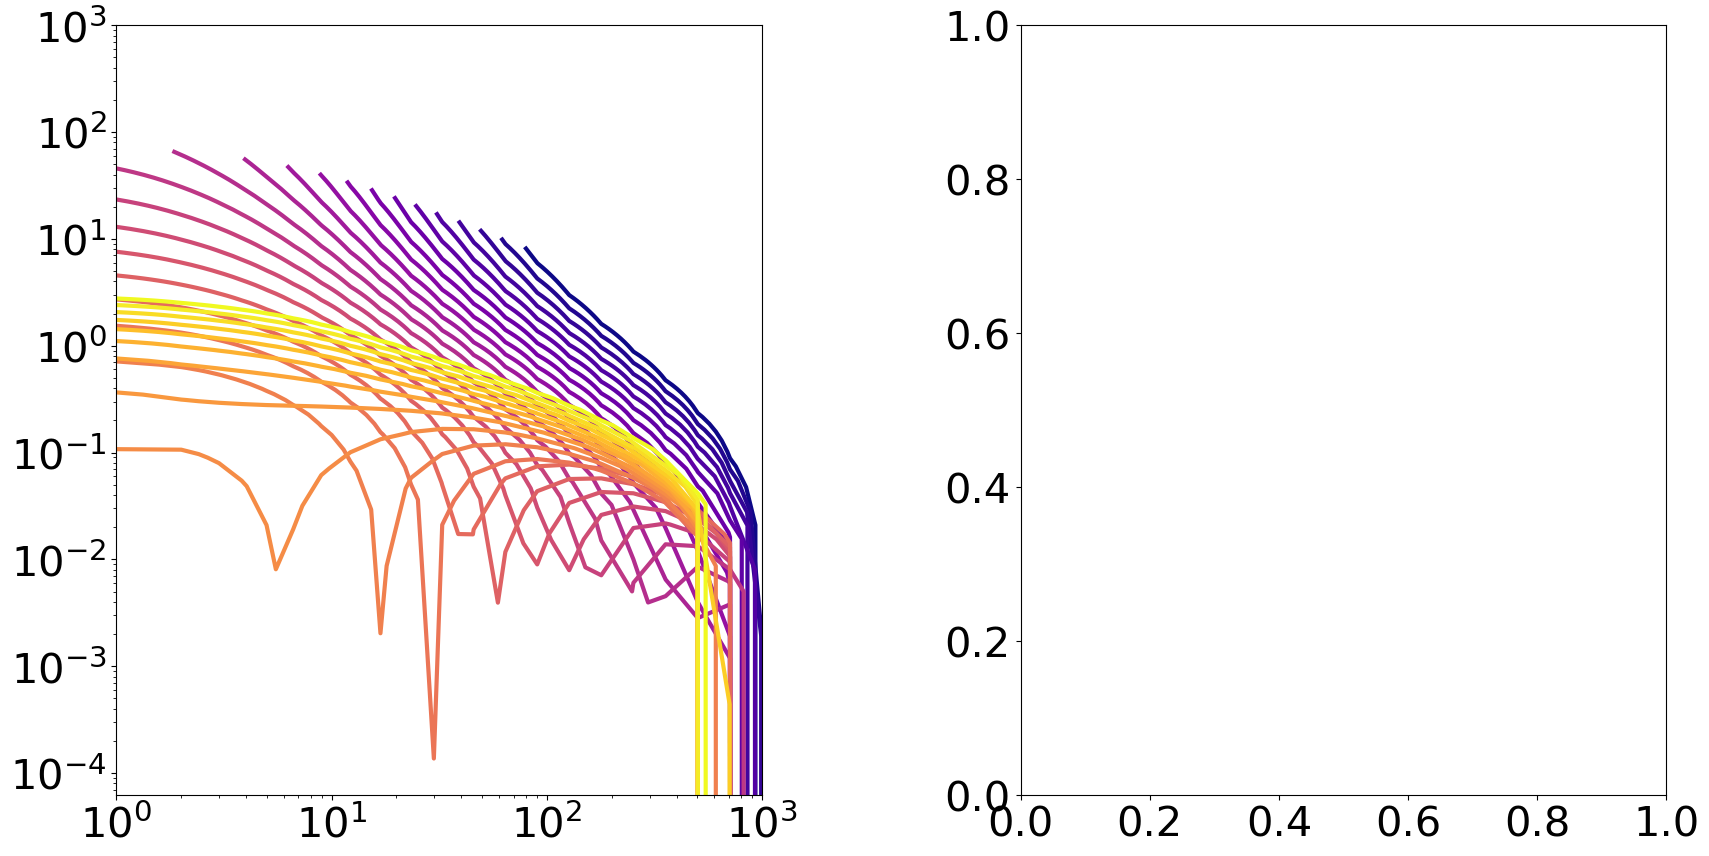

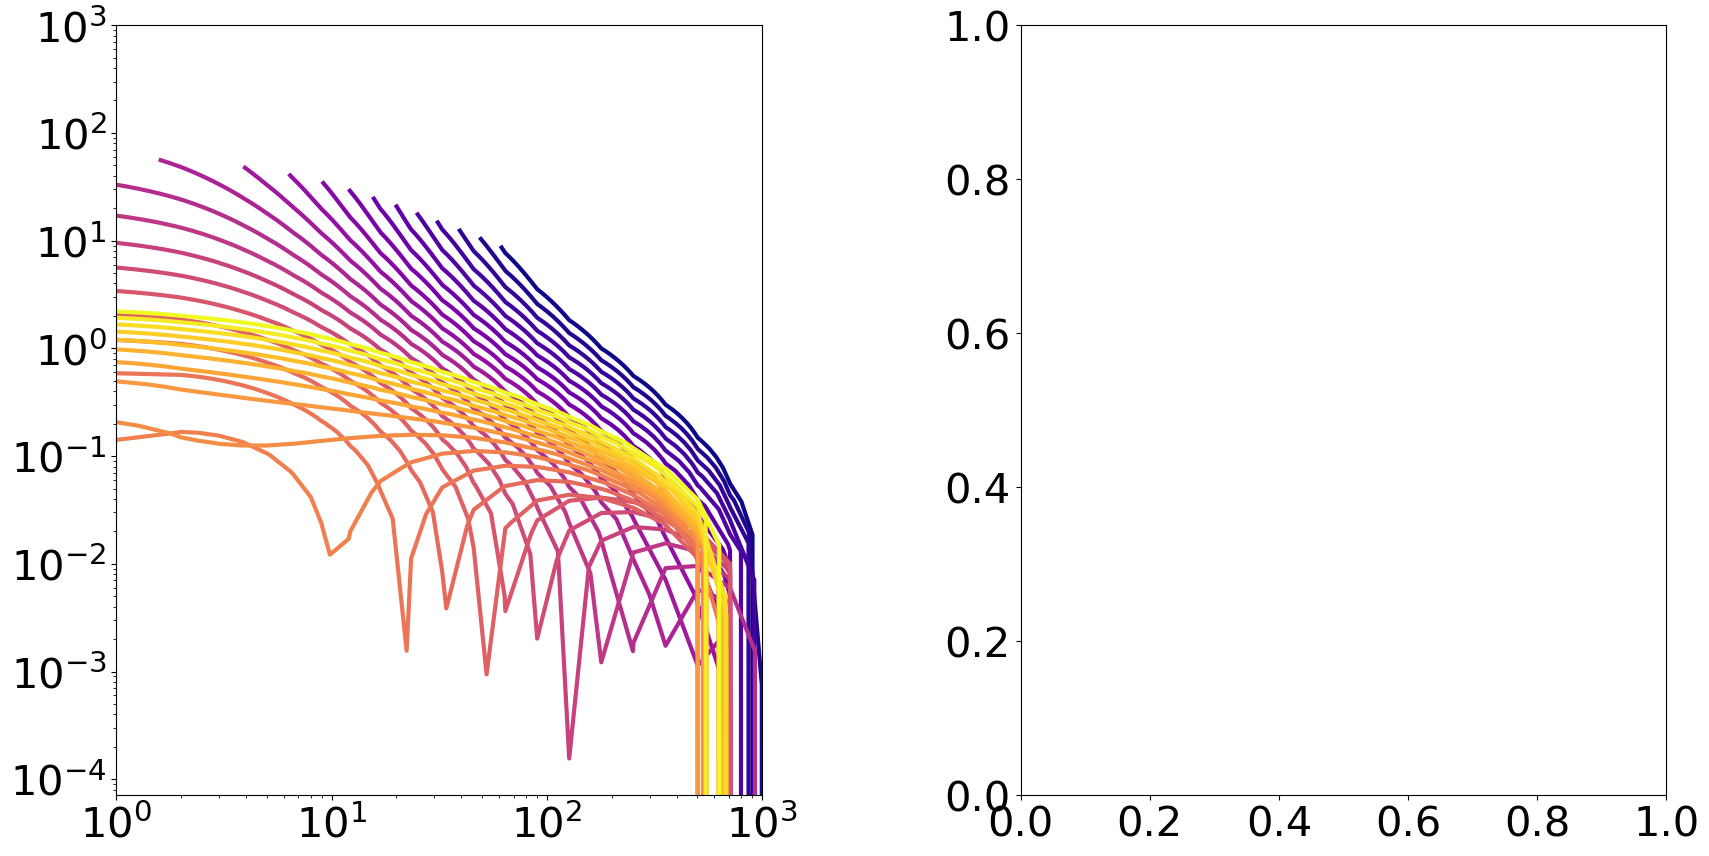

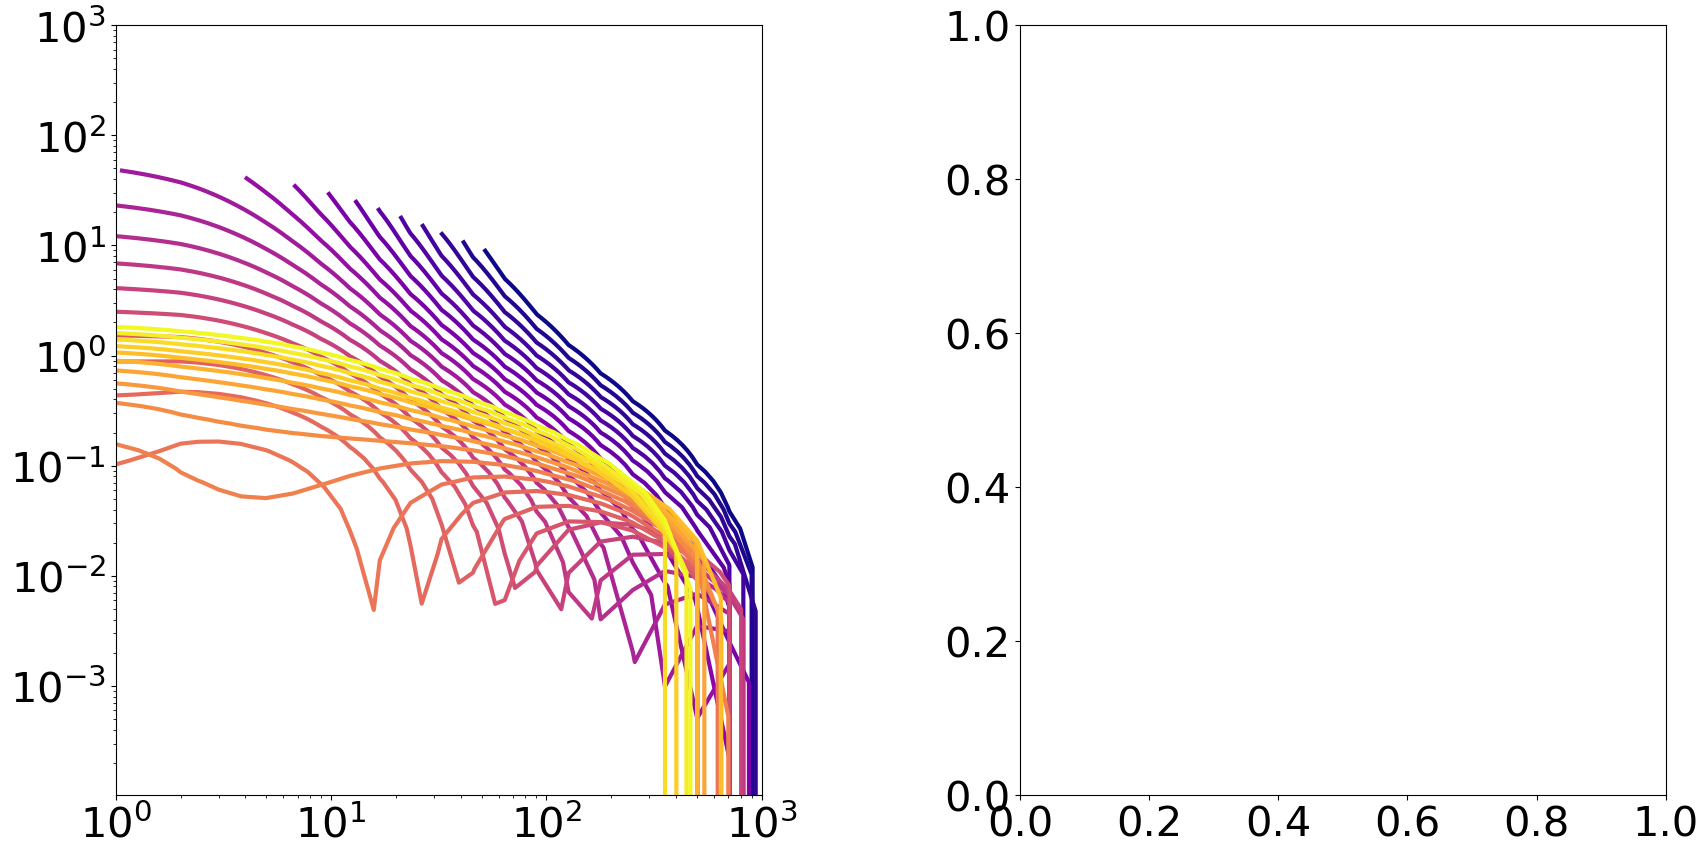

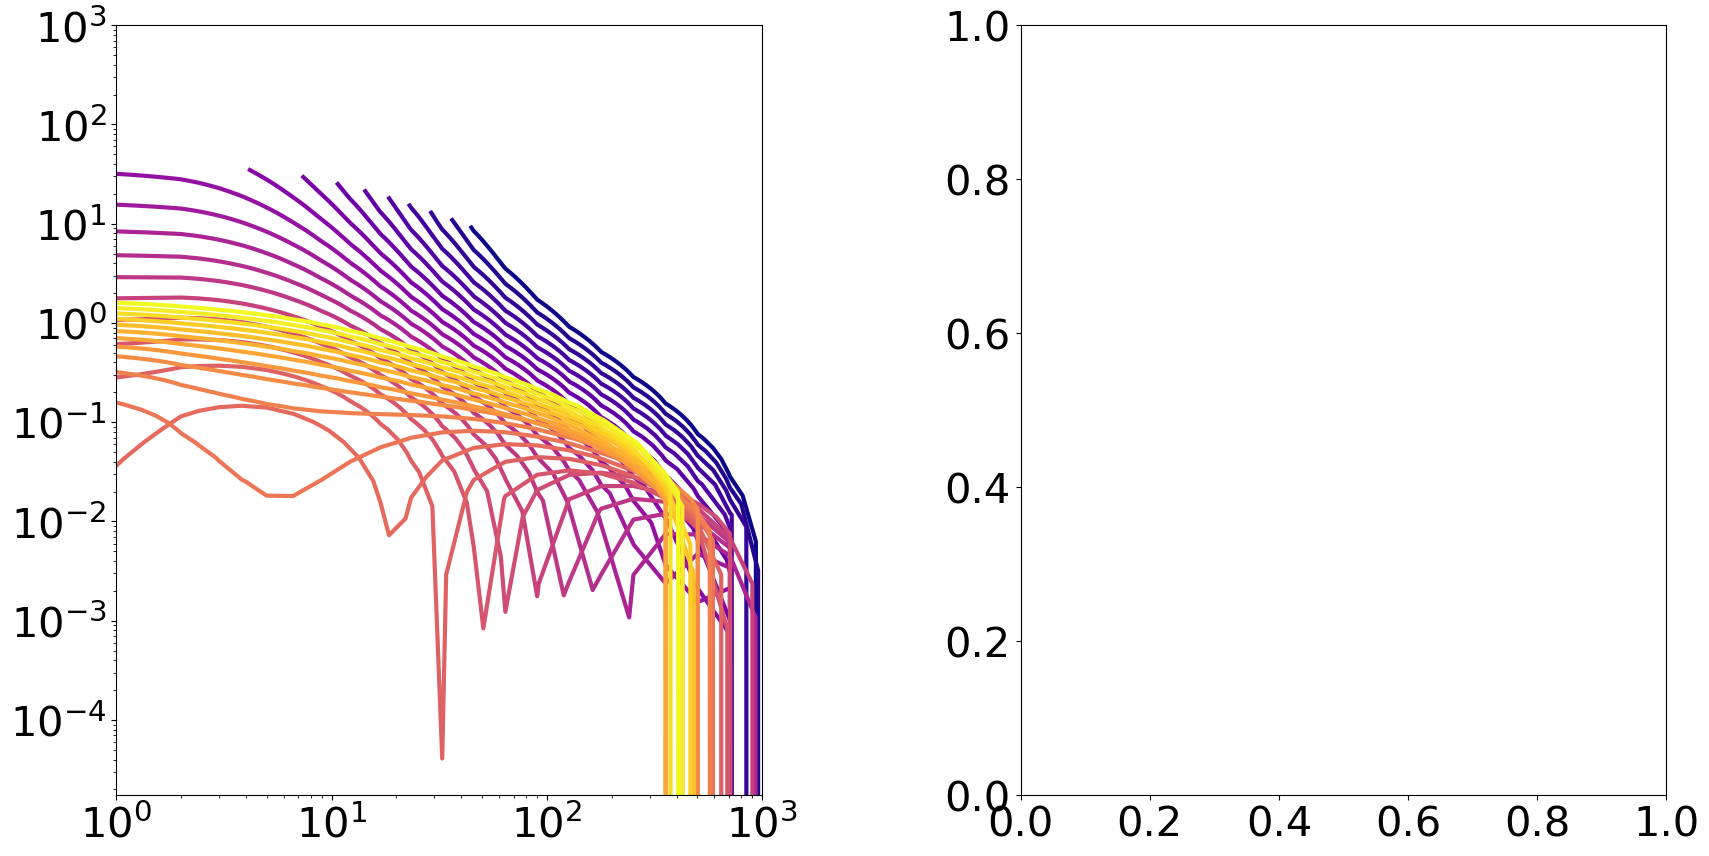

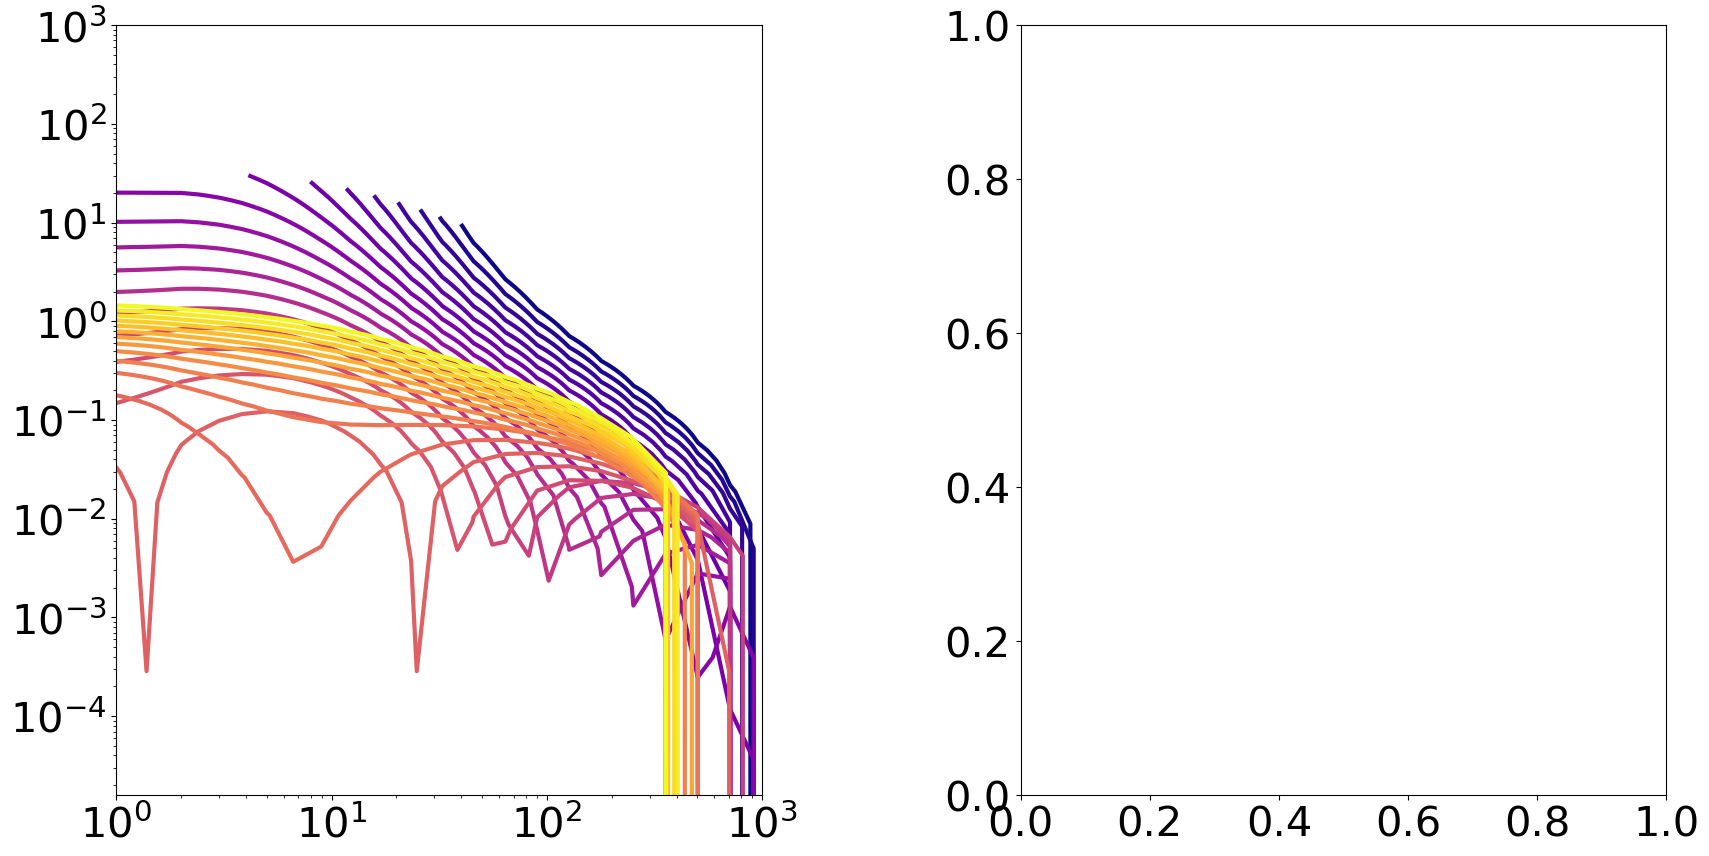

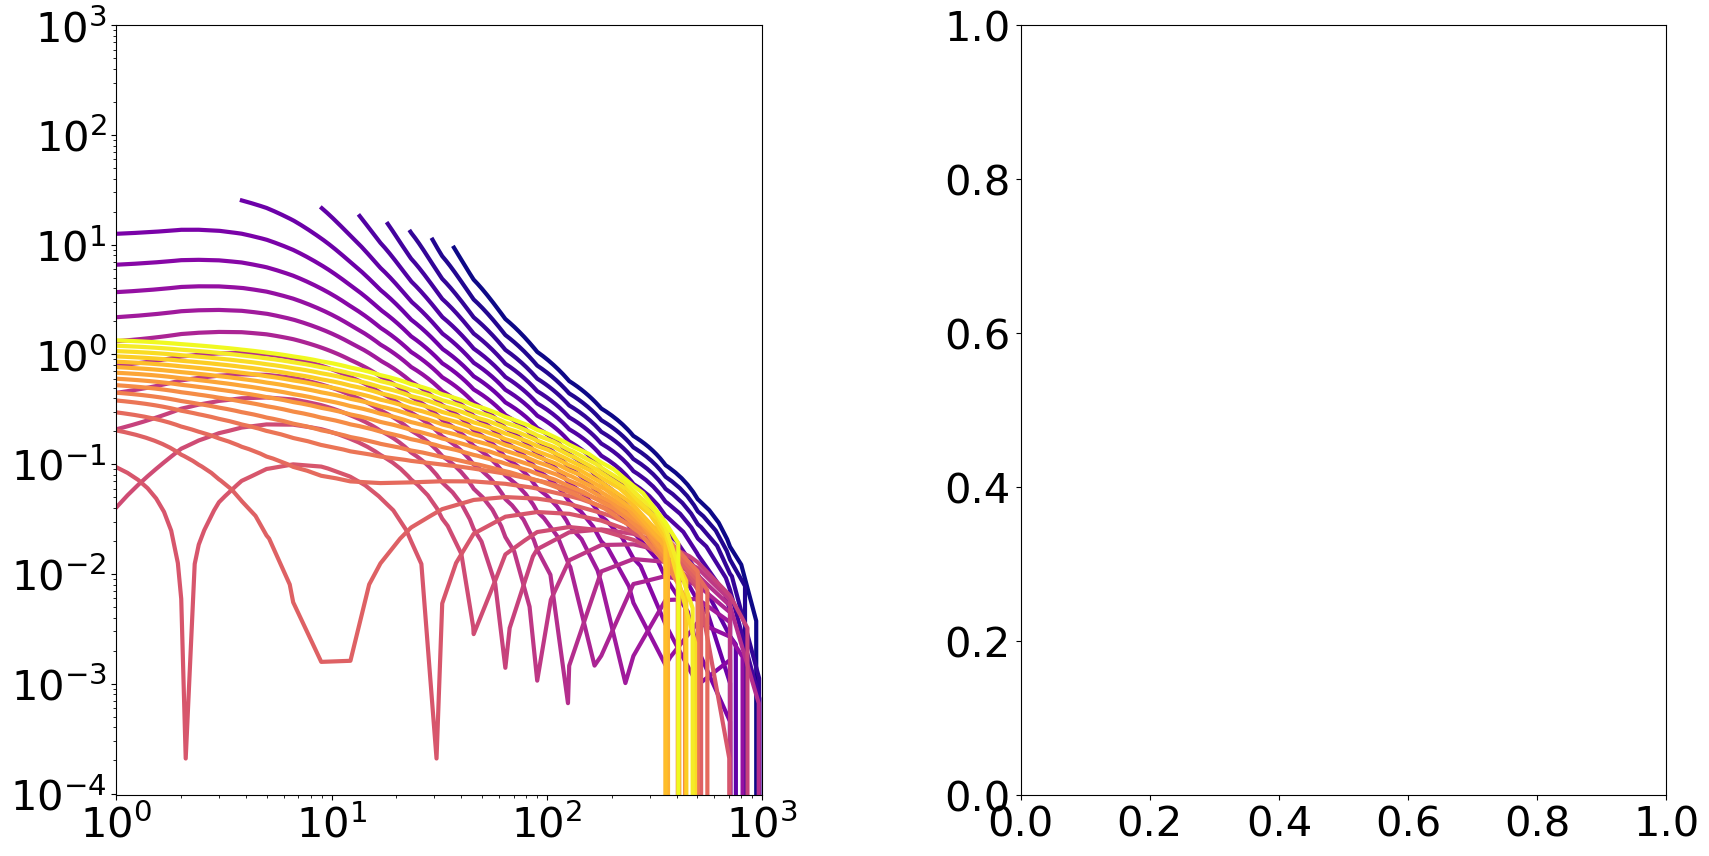

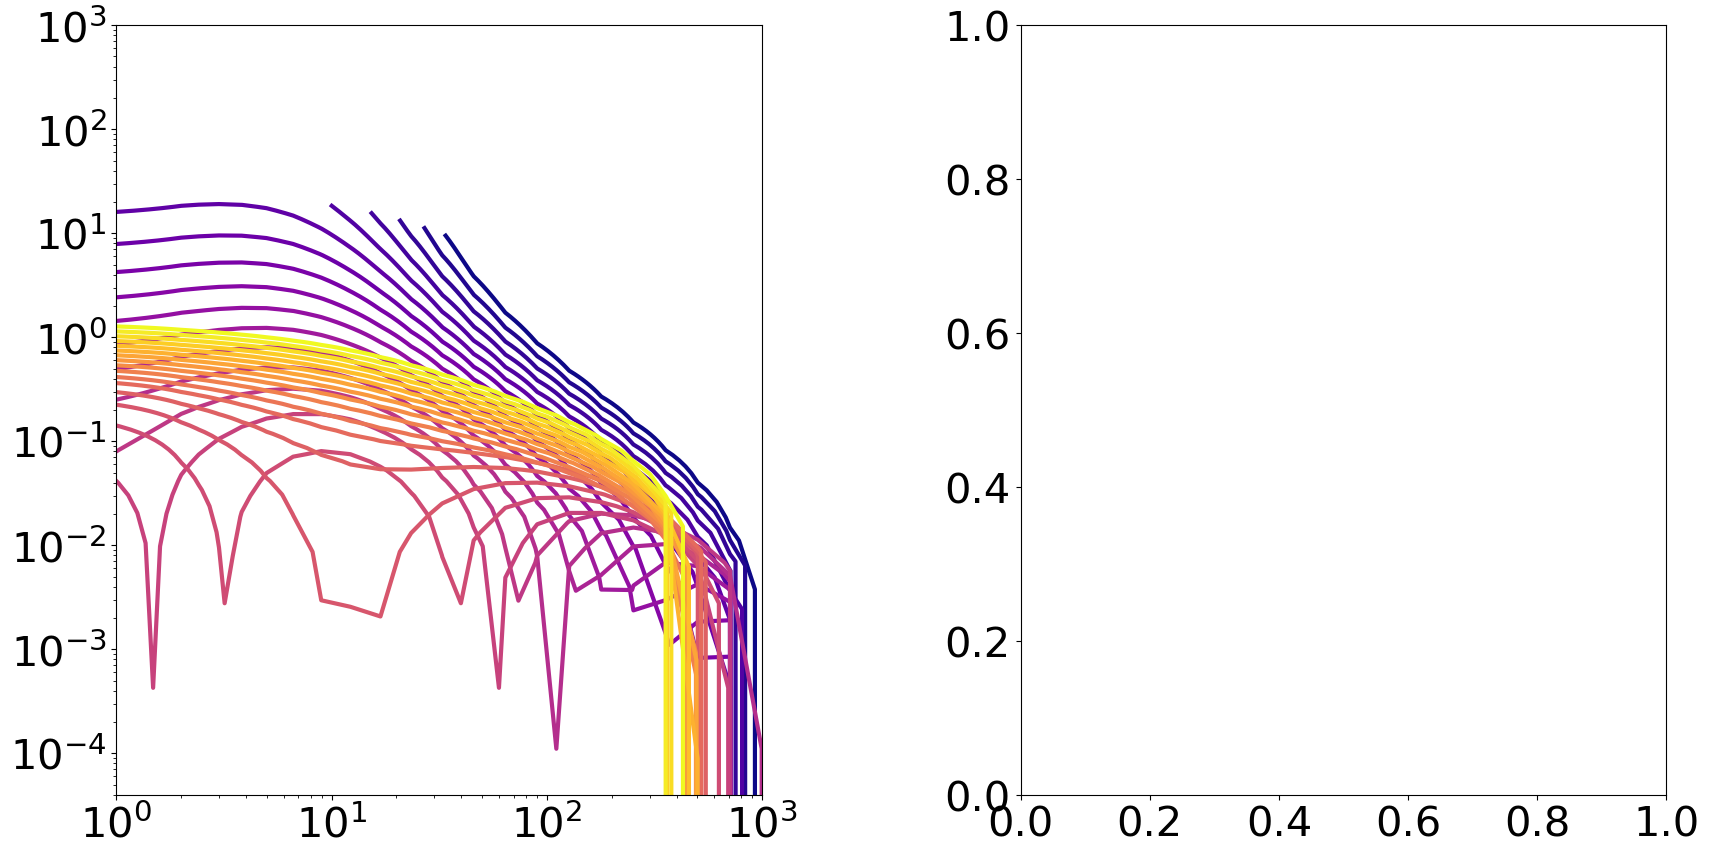

In [24]:
exponents_dataframe = pd.DataFrame(columns=['R0', 'scaled_dbar', 'A', 'alpha'])
colors_scaled_dbar= funcs.color_dict(evolution_pd['scaled_dbar'].unique(),plt.cm.plasma)

fit_params = []
for R0 in tqdm(R0s):
    fig,ax= plt.subplots(1,2,figsize=(20,10))
    plt.subplots_adjust(wspace=0.4)

    delta_s_from_df = evolution_pd['scaled_dbar'].unique()
    for scaled_dbar in delta_s_from_df:
        mini_df = (evolution_pd
            .query(f'R0=={R0} and scaled_dbar=={scaled_dbar}')
            .groupby(['kappa_plot', 'muN'])
            .mean()
            .reset_index())
 
        muN_vals = mini_df['muN'].unique()
        kappa_vals = mini_df['kappa_plot'].unique()
        p_evo_vals = mini_df.pivot(index='muN', columns='kappa_plot', values='p_evo').values

        C =ax[0].contour(kappa_vals, muN_vals, p_evo_vals, levels=[0.5],alpha=0, colors=[colors_scaled_dbar[scaled_dbar]])
        Cx, Cy = C.allsegs[0][0].T
        rescaled_Cy = Cy*scaled_dbar
        try:
            rescaled_Cy = np.abs(rescaled_Cy - rescaled_Cy[-1])
            ax[0].plot(Cx, rescaled_Cy, color=colors_scaled_dbar[scaled_dbar], label = rf'${scaled_dbar:.2e}$')
            #fit Cx, rescaled_Cy to power law
            try:
                fit = np.polyfit(np.log(Cx)[:-2], np.log(rescaled_Cy)[:-2], 1)
                fit_fn = np.poly1d(fit)
                
                exponents_dataframe = pd.concat((exponents_dataframe, pd.DataFrame({'R0':R0, 'scaled_dbar':scaled_dbar, 'A':np.exp(fit_fn[0]), 'alpha':fit_fn[1]},index=[0] )))
            except LinAlgError:
                continue
            except TypeError:
                continue            
        except IndexError:
            continue

    # plt.close(fig)
        ax[0].set_xscale('log')
        ax[0].set_yscale('log')

In [28]:
R0

2.8231080866430855

In [29]:
# pd.DataFrame({'R0':R0, 'scaled_dbar':scaled_dbar, 'A':np.exp(fit_fn[0]), 'alpha':fit_fn[1]}, index=[0]);
# exponents_dataframe = pd.concat((exponents_dataframe, pd.DataFrame({'R0':R0, 'scaled_dbar':scaled_dbar, 'A':np.exp(fit_fn[0]), 'alpha':fit_fn[1]},index=[0] )));
# pd.concat((exponents_dataframe, pd.DataFrame({'R0':R0, 'scaled_dbar':scaled_dbar, 'A':np.exp(fit_fn[0]), 'alpha':fit_fn[1]},index=[0] )))
exponents_dataframe

R0  scaled_dbar             A     alpha
0    1.5     0.011721  1.037111e+23 -7.969765
0    1.5     0.013738  5.063233e+08 -3.096495
0    1.5     0.016103  4.332900e+06 -2.390883
0    1.5     0.018874  5.873115e+05 -2.109230
0    1.5     0.022122  1.416305e+05 -1.909280
..   ...          ...           ...       ...
0   10.0     0.529832  1.360919e+00 -0.528302
0   10.0     0.621017  1.505653e+00 -0.517878
0   10.0     0.727895  1.724844e+00 -0.523889
0   10.0     0.853168  1.924832e+00 -0.519581
0   10.0     1.000000  2.251686e+00 -0.535127

[299 rows x 4 columns]

In [30]:
exponents_dataframe['kappa_star'] = exponents_dataframe['A']**(-1/exponents_dataframe['alpha'])

In [31]:
delta

1.0

In [32]:
R0s[3]

2.8231080866430855

In [33]:
delta_s_from_df[18]

0.17433288221999882

In [34]:
R0s[0]

1.5

In [35]:
delta_s_from_df[16]

0.12689610031679222

In [36]:
def get_yp(R0,kappa,N):
    ts, solution= integrate_trajectory(R0,kappa,N)
    S,I = solution
    x,y = S/N, I/N
    return np.max(y)



In [37]:
# muN_vals

In [38]:
np.log10(N)

8.0

In [39]:
sps.lambertw(-R0*np.exp(-R0)).real

-0.20615819831694907

In [40]:
delta_s_from_df[18]

0.17433288221999882

In [41]:
color=np.array((249,193,51))
color/255

array([0.97647059, 0.75686275, 0.2       ])

In [42]:
# import matplotlib as mpl
# mpl.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth
# mpl.rcParams['hatch.linewidth'] = 8.0  # previous svg hatch linewidth
# from matplotlib.hatch import Shapes, HatchPattern



# class CustomHatch(HatchPattern):
#     def __init__(self, hatch, density):
#         # Define the shape, rotation, and spacing of the hatches
#         super().__init__(
#             fill=False,
#             shapes=[
#                 Shapes.horizontal(0, density)  # Adjust density for closer or sparser lines
#             ]
#         )

# plt.register_hatch_pattern('custom_hatch', CustomHatch('/', 20))  # Smaller number = denser


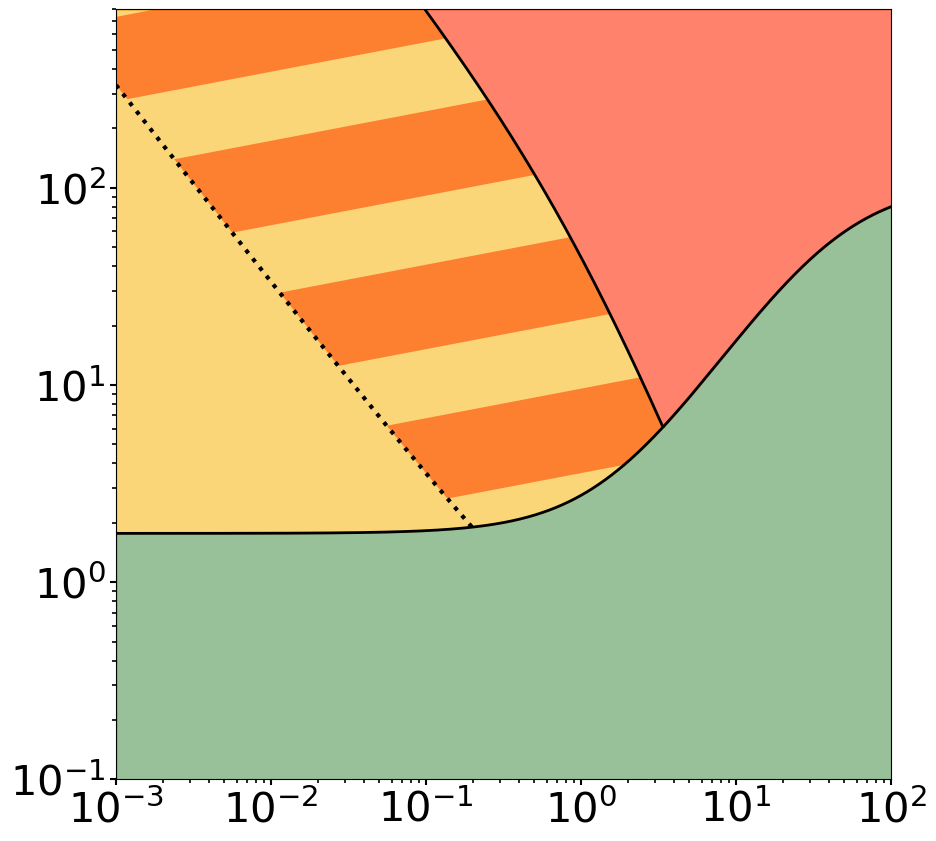

In [43]:
colors_scaled_dbar= funcs.color_dict(evolution_pd['scaled_dbar'].unique(),plt.cm.plasma)
delta_s_from_df = evolution_pd['scaled_dbar'].unique()
fig_ghost,ax_ghost = plt.subplots(1,1,figsize=(1,1))
plt.close(fig_ghost)
for R0 in [R0s[3]]:
    fig,ax= plt.subplots(1,1,figsize=(10,10))
    plt.subplots_adjust(wspace=0.3)
    
    for i_d, scaled_dbar in enumerate(delta_s_from_df[np.array([15])]):
        mini_df = (evolution_pd
            .query(f'R0=={R0} and scaled_dbar=={scaled_dbar}')
            .groupby(['kappa_plot', 'muN'])
            .mean()
            .reset_index())
        muN_vals = mini_df['muN'].unique()
        kappa_vals = mini_df['kappa_plot'].unique()
        p_evo_vals = mini_df.pivot(index='muN', columns='kappa_plot', values='p_evo').values

        

        C =ax_ghost.contour(kappa_vals, muN_vals, p_evo_vals, levels=[0.5],alpha=0)
        Cx, Cy = C.allsegs[0][0].T
        rescaled_Cy = Cy*scaled_dbar
        rescaled_Cy_subtracted = np.abs(rescaled_Cy - rescaled_Cy[-1]+1e-4)
    
        #fit Cx, rescaled_Cy to power law
        try:
            fit = np.polyfit(np.log(Cx[:-1]), np.log(rescaled_Cy_subtracted)[:-1], 1)
            fit_fn = np.poly1d(fit)
            exponent = fit_fn[1] 
        except LinAlgError:
            continue   

        kstar = (R0/(R0-1))**2 /scaled_dbar
        rescaled_Cx = Cx/kstar
        xs= np.logspace(-2,3,500)
        kappa_xs= xs*kstar
        yp_vals = np.array([get_yp(R0,kappa,N) for kappa in kappa_xs])

        z_inf_inf = (R0-1)/R0
        if i_d ==0:
            color= 'k'
        else:
            # continue
            color='grey'

        equal_proba_point_kappa_inf = np.log(2)/((-z_inf_inf-np.log(1-z_inf_inf)))#*delta_s_from_df)
        equal_proba_point_kappa0 = np.log(2)/(np.log(R0)/(R0)*np.power(R0/(R0-1),-1/scaled_dbar))
        law = equal_proba_point_kappa_inf + (equal_proba_point_kappa0-equal_proba_point_kappa_inf)/( 1+  (equal_proba_point_kappa0-equal_proba_point_kappa_inf) *xs**(-exponent))
        ax.plot(1/xs, law , color=color, linestyle='-',lw=2)
        alt_early_late_law = (R0**2*(1 + np.sqrt(-3 + 4*R0))**2*xs**2)/((-1 + R0)**2*(-2 + 2*R0 + xs + np.sqrt(-3 + 4*R0)*xs)*scaled_dbar)
        alt_ci_law = scaled_dbar/(4*yp_vals)

        alt_ci_law_2 = -2*scaled_dbar/(yp_vals*sps.lambertw(-1/(2*N**2 * yp_vals**3 * scaled_dbar),k=-1).real)
        ax.plot(1/xs[alt_ci_law>=law],alt_ci_law[alt_ci_law>=law],color='black',ls=':')
    
        ax.plot(1/xs[alt_early_late_law>=law],alt_early_late_law[alt_early_late_law>=law],color='black',ls='-',lw=2)
    early_late_law =  2* R0**3/(R0-1)**2 * xs
    
    ci_law = R0**2/ (R0-1)**3 * xs

    
    
    # ax.plot(1/xs[early_late_law>=law],early_late_law[early_late_law>=law],color='black')
    

    ax.set_xscale('log')
    ylogged = True

    if ylogged:
        ax.set_yscale('log')
        ax.set_ylim(np.array([1e-1,8e2]))
        ax.set_xlim(np.array([1/1e3,1/1e-2]))
    else:
        ax.set_ylim((0,60))

    ax.fill_between(1/xs, 1e-1*np.ones_like(law), law, color='darkgreen', alpha=0.4)
    ax.fill_between(1/xs, np.maximum(law,alt_early_late_law), 8e2*np.ones_like(law), color='tomato', alpha=0.8)
    ax.fill_between(1/xs[alt_early_late_law>=law], law[alt_early_late_law>=law], np.minimum(8e2*np.ones_like(law),alt_early_late_law)[alt_early_late_law>=law], color="#F9C133", alpha=0.66)

    # ax.fill_between(1/xs[alt_early_late_law>=law], np.maximum(alt_ci_law,law)[alt_early_late_law>=law], np.minimum(8e2*np.ones_like(law),alt_early_late_law)[alt_early_late_law>=law], color='orangered', alpha=0.4, hatch='/',facecolor='none')

    #create fill betweens manually


    for i in range(0,10):
        bottom_line = (6**i)*1e-1 *(xs)**-.15 #* np.ones_like(law) #       bottom_line = (6**i)*1e-1 
        top_line = (6**(i+.55))*1e-1 *(xs)**-.15 # * np.ones_like(law) #        top_line = (6**(i+.5))*1e-1 

        # bottom_line = bottom_line[np.logical_and(bottom_line>=alt_ci_law_2
        
        
        ax.fill_between(1/xs, np.maximum(np.minimum(np.maximum(bottom_line,alt_ci_law),alt_early_late_law),law), np.maximum(np.minimum(np.maximum(top_line,alt_ci_law),alt_early_late_law),law), color='orangered', alpha=0.6,lw=0)

        #increase tick width and size, do the same for minor ticks
        ax.tick_params(width=1.5, length=4)
        ax.tick_params(which='minor', width=1.2, length=3)

# plt.savefig(output_folder+f'/fig2_inv_R0{R0:.2f}_delta{scaled_dbar:.2f}.svg', bbox_inches='tight')